# Location clustering

## Finding the location of the users given their time of response

 With the Usage Events, I'm trying to cluster the users given their qverqge response time, on each request.
 I'm going to calculate the mean elapsed time per request per user, divide it by the mean time for the request
 Then take the average of those grades to cluster the users.
 
 I will try to add the concurrencies as well

## Importing libraries

In [1]:
import numpy as np
import pandas
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing
import seaborn as sns

## Importing functions

In [2]:
def time_format (str_date):
    try :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S.%f')
    except :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S')
    return datetime_object.strftime('%Y%m%d%H%M%S.%f')

def time_format_delay (str_date):
    try :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S.%f')
    except :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S')
    hour_=datetime.timedelta(hours=5)
    second=datetime.timedelta(seconds=6)
    datetime_object-=-seconds+hour_
    return datetime_object.strftime('%Y%m%d%H%M%S.%f')

def server_translate(ip): 
    a=np.array([
        ['nxp1','172.27.8.41'],
        ['nxp2', '172.27.8.45'],
        ['nxp3','172.27.8.82'],
        ['nxp4' ,'172.27.8.84'],
        ['nxp5' ,'172.27.8.85'],
        ['nxp6' ,'172.27.8.86'],
        ['nxp7' ,'172.27.8.87'],
        ['nxp8' ,'172.27.8.90'],
        ['nxp9' ,'172.27.8.91'],
        ['nxp10' ,'172.27.8.93'],
        ['nxp11' ,'172.27.8.47'],
        ['nxp12' ,'172.27.8.49'],
        ['nxp13' ,'172.27.8.46']])
    if ip in a[:,1] :
        return a[a[:,1]==ip,0][0]
    else :
        return 'Unknown IP'
    
def transfo_date_delay(str_date):
    try :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S.%f')
    except :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S')
    hour_=datetime.timedelta(hours=5)
    second=datetime.timedelta(seconds=6)
    datetime_object+=hour_-second
    return datetime_object

def transfo_date(str_date):
    try :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S.%f')
    except :
        datetime_object = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S')
    return datetime_object
def detect(str_date):
    if type(str_date)==str :
        print(str_date)
    return str_date

def troncat_date(datess):
    res=datess.replace(year=datess.year, month=datess.month, day=datess.day,hour=0, minute=0, second=0, microsecond=0)
    return res
def troncat_hour_week(datess):
    res=datess.hour
    week=datess.isoweekday()
    return week*25+res
def month(datess):
    return datess.month
def day(datess):
    return datess.day

def perday(datess):
    yearq=datess.year
    st=datetime.date(day=1,month=1,year=yearq)
    d=datess.date()
    td=d-st
    jours=td.days
    return 365*(yearq-2017)+jours
def perhour(datess):
    yearq=datess.year
    st=datetime.date(day=1,month=1,year=yearq)
    d=datess.date()
    td=d-st
    jours=td.days
    return (365*(yearq-2017)+jours)*24+datess.hour

def nbr_week(datess):
    return datess.isocalendar()[1]

## Retrieving the data

The data in question comes frome Server crash concurrencies (concurrencies but no crashes)

In [10]:
Dataset=pandas.read_csv('Total concurrenciesv2.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]

## First attempt

On this first attempt, I will only take in count the means, without excluding high values and takign concurrencies into account.

In [15]:
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['UserID','Normalized Req user']]
Res2=Res2.groupby(by='UserID').mean()
Res2.to_csv('Mean_time user.csv')

### Starting the clustering problem

In [63]:
data=pandas.read_csv('Mean_time user.csv')
data=data.sort_values(by='Normalized Req user')
X=data.loc[:,['UserID','Normalized Req user']].values


In [66]:
a=X.shape[0]
l=[0]*a
print(data.head())


        UserID  Normalized Req user
4088     63910             0.096704
2774     61705             0.133262
7735   9715446             0.133693
4228    121946             0.135186
8531  22221877             0.136389


In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
onehotencoder=OneHotEncoder(categorical_features =[0])
X=onehotencoder.fit_transform(X).toarray()

In [29]:
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)

1
2
3
4
5
6
7
8
9


<function matplotlib.pyplot.show>

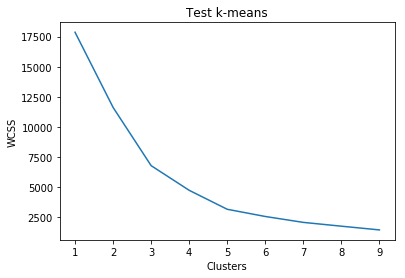

In [30]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,10):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

In [32]:
kmeans = KMeans(n_clusters =4, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)

[2 2 0 ... 0 3 2]


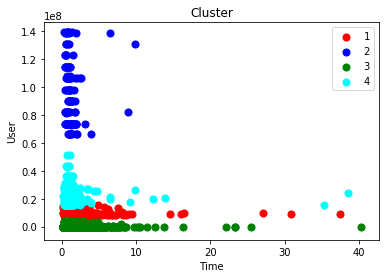

In [34]:
X=data.loc[:,['UserID','Normalized Req user']].values

plt.scatter(X[y_kmeans ==0,1],X[y_kmeans ==0,0],s=50,c='red',label ='1')
plt.scatter(X[y_kmeans ==1,1],X[y_kmeans ==1,0],s=50,c='blue',label ='2')
plt.scatter(X[y_kmeans ==2,1],X[y_kmeans ==2,0],s=50,c='green',label ='3')
plt.scatter(X[y_kmeans ==3,1],X[y_kmeans ==3,0],s=50,c='cyan',label ='4')

#plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0],s=100 ,c='yellow', label = 'Center')
plt.title('Cluster')
plt.xlabel('Time')
plt.ylabel('User')
plt.legend()
plt.show
# =============================================================================
print(y_kmeans)
np.savetxt('Res_.csv', y_kmeans,delimiter=',',fmt='%s')

In [4]:
Y=data.loc[:,['UserID','Normalized Req user']].values

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehotencoder=OneHotEncoder(categorical_features =[0])
Y=onehotencoder.fit_transform(Y).toarray()

1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

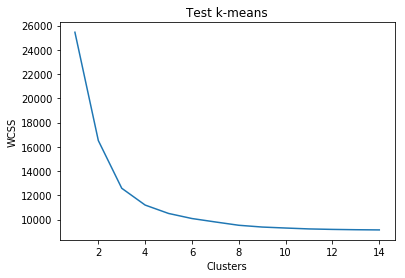

In [37]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters =3, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(Y)

In [39]:
data['Cluster']=y_kmeans
data.to_csv('Cluster-v1.csv')

<function matplotlib.pyplot.show>

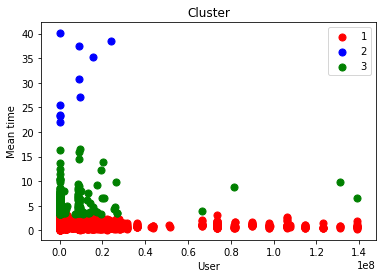

In [9]:
Y=data.loc[:,['UserID','Normalized Req user']].values
#labelencoder_X = LabelEncoder()
#Y[:,0] = labelencoder_X.fit_transform(Y[:,0])


plt.scatter(Y[y_kmeans ==0,0],Y[y_kmeans ==0,1],s=50,c='red',label ='1')
plt.scatter(Y[y_kmeans ==1,0],Y[y_kmeans ==1,1],s=50,c='blue',label ='2')
plt.scatter(Y[y_kmeans ==2,0],Y[y_kmeans ==2,1],s=50,c='green',label ='3')
plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show

## Second Attempt with the OrgID
Making clusters of OrgIDd

In [5]:
Dataset2=pandas.read_csv('data_OrgID.csv')
User_requests=Dataset2[['OrgID','EventID','Elapsed']]
User_requests=User_requests.groupby(by=['OrgID','EventID']).mean()
User_requests.to_csv('Usrreq2.csv')
User_requests=pandas.read_csv('Usrreq2.csv')
User_requests.columns=['OrgID','EventID','Mean User requests']
Req=Dataset2[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['OrgID','Normalized Req user']]
Res2=Res2.groupby(by='OrgID').mean()
Res2.to_csv('Mean_time user2.csv')

In [15]:
data2=pandas.read_csv('Mean_time user2.csv')
data2=data2.sort_values(by='Normalized Req user')
Y=data2.loc[:,['OrgID','Normalized Req user']].values


In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehotencoder=OneHotEncoder(categorical_features =[0])
Y=onehotencoder.fit_transform(Y).toarray()

1
2
3
4
5
6
7
8
9


<function matplotlib.pyplot.show>

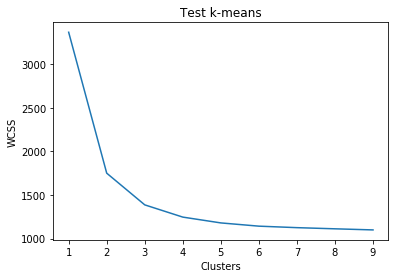

In [17]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,10):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

<function matplotlib.pyplot.show>

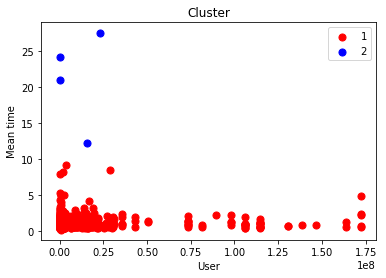

In [19]:
kmeans = KMeans(n_clusters =2, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(Y)
Y=data2.loc[:,['OrgID','Normalized Req user']].values
plt.scatter(Y[y_kmeans ==0,0],Y[y_kmeans ==0,1],s=50,c='red',label ='1')
plt.scatter(Y[y_kmeans ==1,0],Y[y_kmeans ==1,1],s=50,c='blue',label ='2')
#plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='3')
plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show

## Third attempt with the OrgId and removing long times
then combining the two results 

In [4]:
Dataset2=pandas.read_csv('data_OrgID.csv')


In [5]:
print(Dataset2['Elapsed'].mean())

2988.5107485076296


In [11]:

Dataset2=Dataset2.loc[Dataset2['Elapsed']<5000,:]
User_requests=Dataset2[['OrgID','EventID','Elapsed']]
User_requests=User_requests.groupby(by=['OrgID','EventID']).mean()
User_requests.to_csv('Usrreq3.csv')
User_requests=pandas.read_csv('Usrreq3.csv')
User_requests.columns=['OrgID','EventID','Mean User requests']
Req=Dataset2[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['OrgID','Normalized Req user']]
Res2=Res2.groupby(by='OrgID').mean()
Res2.to_csv('Mean_time user3.csv')

In [32]:
data2=pandas.read_csv('Mean_time user3.csv')
data2=data2.sort_values(by='Normalized Req user')
Y=data2.loc[:,['OrgID','Normalized Req user']].values


In [33]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehotencoder=OneHotEncoder(categorical_features =[0])
Y=onehotencoder.fit_transform(Y).toarray()
print(Y.shape)

(1070, 1071)


ValueError: Expected 2D array, got 1D array instead:
array=[0.15615525 0.27796909 0.34221743 ... 2.39416982 2.5108121  3.46281124].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [34]:
print(Y)

[[0.         0.         0.         ... 0.         0.         0.15615525]
 [0.         0.         0.         ... 0.         0.         0.27796909]
 [0.         0.         0.         ... 0.         0.         0.34221743]
 ...
 [0.         0.         0.         ... 0.         0.         2.39416982]
 [0.         0.         0.         ... 0.         0.         2.5108121 ]
 [0.         0.         0.         ... 0.         0.         3.46281124]]


1
2
3
4
5
6
7
8
9
10
11
12
13
14


ValueError: x and y must have same first dimension, but have shapes (9,) and (14,)

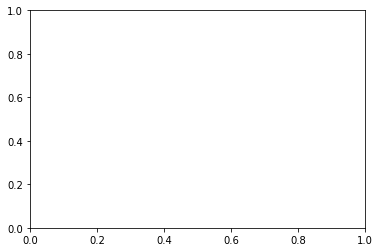

In [35]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

<function matplotlib.pyplot.show>

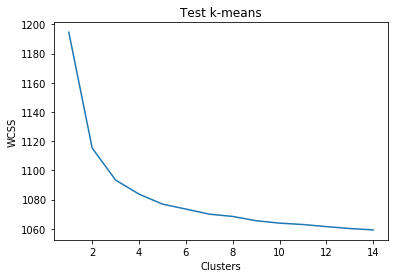

In [36]:
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

<function matplotlib.pyplot.show>

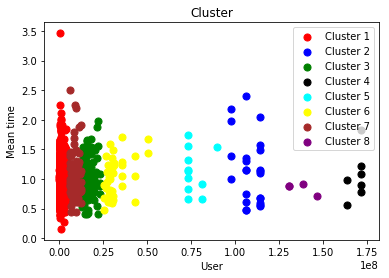

In [39]:
kmeans = KMeans(n_clusters =8, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(Y)
X=data2.loc[:,['OrgID','Normalized Req user']].values
plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show

In [51]:
X=data2.iloc[:,1].values
data3=data2

print(X.shape)
a=X.shape[0]
l=[0]*a
data3['dum']=l
Y=data2.iloc[:,[1,2]].values

(1070,)


In [52]:
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
Y=sc_X.fit_transform(Y)

In [53]:
print(Y)

[[-2.54635765  0.        ]
 [-2.19090669  0.        ]
 [-2.00343098  0.        ]
 ...
 [ 3.98413544  0.        ]
 [ 4.32449588  0.        ]
 [ 7.10241514  0.        ]]


1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

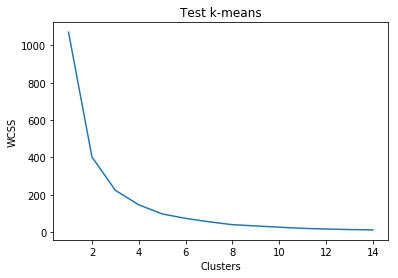

In [54]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(Y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

<function matplotlib.pyplot.show>

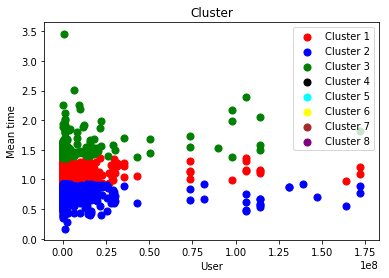

In [59]:
kmeans = KMeans(n_clusters =3, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(Y)
X=data2.loc[:,['OrgID','Normalized Req user']].values
plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show
data2.to_csv('Clustering_orgID.csv')

## Analysis of Events ID (without orgID and Elapsed<5000)

In [69]:
Dataset=pandas.read_csv('Total concurrenciesv2.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.loc[User_requests['Elapsed']<5000,:]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq4.csv')
User_requests=pandas.read_csv('Usrreq4.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['UserID','Normalized Req user']]
Res2=Res2.groupby(by='UserID').mean()
Res2.to_csv('Mean_time user4.csv')

In [102]:
data=pandas.read_csv('Mean_time user4.csv')
data=data.sort_values(by='Normalized Req user')
X=data.loc[:,['UserID','Normalized Req user']].values
a=X.shape[0]
l=[0]*a
print(data.head())
data['dum']=l
X=data.loc[:,['Normalized Req user','dum']].values

In [103]:
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

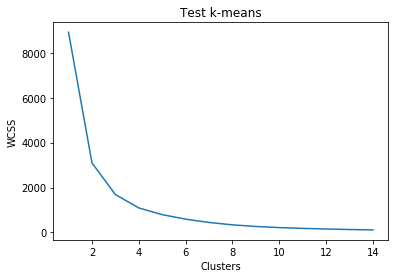

In [73]:

from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

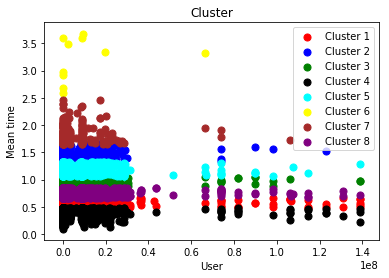

In [104]:
kmeans = KMeans(n_clusters =8, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
X=data.loc[:,['UserID','Normalized Req user']].values
plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show
data['Cluster 8']=y_kmeans

In [105]:
data.to_csv('cluster_events.csv')

## Merging the results from Events and org

In [106]:
Events=pandas.read_csv('cluster_events.csv')
Org=pandas.read_csv('Clustering_orgID.csv')
Trad=pandas.read_csv('data_orgID.csv')
Tab=Org.merge(Trad,how='inner',on='OrgID')
print(Tab.head())
Tab=Tab[['OrgID','Normalized Req user','Cluster 3','Cluster 8','UserID']]
Tab.columns=['OrgID','Normalized Req user org','Cluster 3 org','Cluster 8 org','UserID']
Tab=Tab.merge(Events, how='inner', on='UserID')
print(Tab.head())

   Unnamed: 0    OrgID  Normalized Req user  dum  Cluster 8  Cluster 3  \
0         459  1067673             0.156155    0          7          1   
1         459  1067673             0.156155    0          7          1   
2         459  1067673             0.156155    0          7          1   
3         459  1067673             0.156155    0          7          1   
4         459  1067673             0.156155    0          7          1   

   SessionID  EntryID  UserID EventID  Type WorkspaceID  \
0    3583593        1   62524     NaN     0         NaN   
1    3418679        5   62524     NaN     3    uBBaQgfD   
2    3418679        1   62524     NaN     0         NaN   
3    3418679        2   62524     NaN     3    uBBaQgfD   
4    3418679        3   62524     NaN     3    uBBaQgfD   

                 StartTime                  EndTime  Elapsed     ServerIP  
0  2018-04-06 15:33:43.763  2018-04-06 15:33:45.509     1746  172.27.8.90  
1  2018-03-05 13:10:56.519  2018-03-05 13:10:57.

In [107]:
Tab=Tab[['OrgID','Normalized Req user org','Cluster 3 org','Cluster 8 org','UserID','Cluster 3','Cluster 8','Normalized Req user']]
Tab=Tab.drop_duplicates(subset=['UserID','OrgID'])

In [109]:
Tab.to_csv('Testdouble cluster.csv')

## Combining the results from the same 

In [ ]:
Dataset=pandas.read_csv('data_OrgID.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP']]
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.loc[User_requests['Elapsed']<5000,:]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq6.csv')
User_requests=pandas.read_csv('Usrreq6.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['UserID','Normalized Req user']]
Res2=Res2.groupby(by='UserID').mean()
Res2.to_csv('Mean_time user6.csv')

In [162]:
X=Tab.loc[:,['Normalized Req user']].values
a=X.shape[0]
l=[0]*a
Tab['dum']=l
X=Tab.loc[:,['Normalized Req user','dum']].values
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

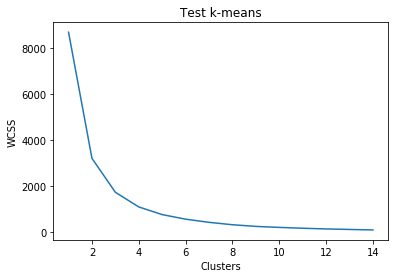

In [150]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

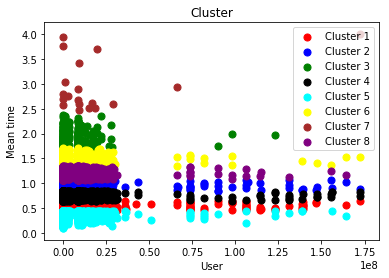

In [163]:
kmeans = KMeans(n_clusters =8, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
X=Tab.loc[:,['UserID','Normalized Req user']].values
plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User')
plt.ylabel('Mean time')
plt.legend()
plt.show
Tab['Cluster 8']=y_kmeans

In [164]:
Tab.to_csv('Users_data2_clusters.csv')

In [165]:
Events=pandas.read_csv('Users_data2_clusters.csv')
Org=pandas.read_csv('Clustering_orgID.csv')
Trad=pandas.read_csv('data_orgID.csv')
Tab=Org.merge(Trad,how='inner',on='OrgID')
print(Tab.head())
Tab=Tab[['OrgID','Normalized Req user','Cluster 3','Cluster 8','UserID']]
Tab.columns=['OrgID','Normalized Req user org','Cluster 3 org','Cluster 8 org','UserID']
Tab=Tab.merge(Events, how='inner', on='UserID')
Tab=Tab[['OrgID','Normalized Req user org','Cluster 3 org','Cluster 8 org','UserID','Cluster 3','Cluster 8','Normalized Req user']]
Tab=Tab.drop_duplicates(subset=['UserID','OrgID'])

   Unnamed: 0    OrgID  Normalized Req user  dum  Cluster 8  Cluster 3  \
0         459  1067673             0.156155    0          7          1   
1         459  1067673             0.156155    0          7          1   
2         459  1067673             0.156155    0          7          1   
3         459  1067673             0.156155    0          7          1   
4         459  1067673             0.156155    0          7          1   

   SessionID  EntryID  UserID EventID  Type WorkspaceID  \
0    3583593        1   62524     NaN     0         NaN   
1    3418679        5   62524     NaN     3    uBBaQgfD   
2    3418679        1   62524     NaN     0         NaN   
3    3418679        2   62524     NaN     3    uBBaQgfD   
4    3418679        3   62524     NaN     3    uBBaQgfD   

                 StartTime                  EndTime  Elapsed     ServerIP  
0  2018-04-06 15:33:43.763  2018-04-06 15:33:45.509     1746  172.27.8.90  
1  2018-03-05 13:10:56.519  2018-03-05 13:10:57.

In [166]:
Tab.to_csv('Mergev2.csv')

## Clustering both times

In [110]:
Dataset2=pandas.read_csv('data_OrgID.csv')
Dataset2=Dataset2.loc[Dataset2['Elapsed']<5000,:]
User_requests=Dataset2[['OrgID','EventID','Elapsed']]
User_requests=User_requests.groupby(by=['OrgID','EventID']).mean()
User_requests.to_csv('Usrreq5.csv')
User_requests=pandas.read_csv('Usrreq5.csv')
User_requests.columns=['OrgID','EventID','Mean User requests']
Req=Dataset2[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['OrgID','Normalized Req user']]
Res2=Res2.groupby(by='OrgID').mean()
Res2.to_csv('Mean_time user5.csv')

In [112]:
Dataset=pandas.read_csv('data_OrgID.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP']]
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.loc[User_requests['Elapsed']<5000,:]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq6.csv')
User_requests=pandas.read_csv('Usrreq6.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['UserID','Normalized Req user']]
Res2=Res2.groupby(by='UserID').mean()
Res2.to_csv('Mean_time user6.csv')

In [113]:
Events=pandas.read_csv('Mean_time user6.csv')
Org=pandas.read_csv('Mean_time user5.csv')
Trad=pandas.read_csv('data_OrgID.csv')
Tab=Org.merge(Trad,how='inner',on='OrgID')
print(Tab.head())
Tab=Tab[['OrgID','Normalized Req user','UserID']]
Tab.columns=['OrgID','Normalized Req user org','UserID']
Tab=Tab.merge(Events, how='inner', on='UserID')
print(Tab.head())

   OrgID  Normalized Req user  SessionID  EntryID   UserID EventID  Type  \
0      1             1.018633    3463836        3  2931137     NaN     0   
1      1             1.018633    3463839        1  2931137     NaN     0   
2      1             1.018633    3463839        2  2931137     NaN     0   
3      1             1.018633    3463853        3  2931137     NaN     0   
4      1             1.018633    3463856        1  2931137     NaN     0   

  WorkspaceID                StartTime                  EndTime  Elapsed  \
0         NaN  2018-03-14 00:14:21.923  2018-03-14 00:14:23.538     1615   
1         NaN  2018-03-14 00:14:36.843   2018-03-14 00:14:38.26     1417   
2         NaN  2018-03-14 00:14:39.975  2018-03-14 00:14:41.128     1153   
3         NaN  2018-03-14 00:16:40.255  2018-03-14 00:16:42.579     2324   
4         NaN  2018-03-14 00:16:59.494  2018-03-14 00:17:02.031     2537   

      ServerIP  
0  172.27.8.47  
1  172.27.8.47  
2  172.27.8.47  
3  172.27.8.47  
4

In [115]:
Tab=Tab.drop_duplicates(subset=['UserID','OrgID'])
Tab.to_csv('Cluster_User_Org.csv')

In [134]:

X=Tab.loc[:,['Normalized Req user','Normalized Req user org']].values
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)

[[-0.49953897 -1.98350036]
 [-0.49971021 -1.88150464]
 [ 0.25000054 -1.88030143]
 ...
 [-0.49961011  7.77342683]
 [ 0.19136917  7.80322627]
 [ 0.2369861   7.99619012]]


1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

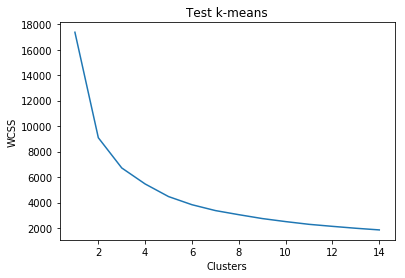

In [130]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

In [135]:
kmeans = KMeans(n_clusters =8, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
X=Tab.loc[:,['Normalized Req user','Normalized Req user org']].values

<function matplotlib.pyplot.show>

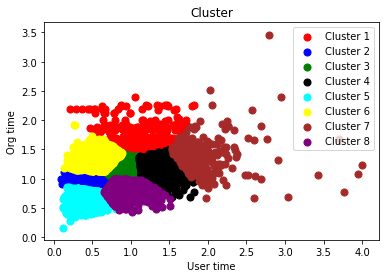

In [136]:

plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User time')
plt.ylabel('Org time')
plt.legend()
plt.show

In [138]:
Tab.to_csv('Clusters_Org_User_Res.csv')

## Analysis on Myprojects

Same project than earlier but only with MyProjects data (ie workspace in liste)

In [35]:
### Getting the list of workspaces of my project
Dataset=pandas.read_csv('data_OrgID.csv')
Dataset=Dataset.drop_duplicates(subset='WorkspaceID')
l=Dataset.loc[:,['WorkspaceID']].values
liste=[]
for i in l :
    if str(i)[2] in ['u','x'] :
        liste.append(str(i)[2:-2])

x84sljJzv
uBBaQgfD
uDphDdvt
uGv5Zj5l
x84sl8NWY
uBBaQgfN
uDpb9dAO
x84slQln
uDpgedwY
uFzvLfw4
uJz7LlIe
ut0hTb3O
uI78Pju7
x1fWBrMv
x84sljOgl
x84slzKL0
x84sljJzW
uM6VbtTe
x84sljIqL
uI78PipW
uIQ2xiUD
uGv5ZhaJ
x84sljOhZ
uM6VbvSM
ueQUN3Bn
uBBaQimY
uGi0LgRl
ueQUN3tH
x84slNfo
x84slTml
uQjsCM4b
x84sljOhT
x84sljOif
uFzvLfvd
ueQUN3tI
x1fWBup6
x84slTar


In [36]:
print(liste)

['x84sljJzv', 'uBBaQgfD', 'uDphDdvt', 'uGv5Zj5l', 'x84sl8NWY', 'uBBaQgfN', 'uDpb9dAO', 'x84slQln', 'uDpgedwY', 'uFzvLfw4', 'uJz7LlIe', 'ut0hTb3O', 'uI78Pju7', 'x1fWBrMv', 'x84sljOgl', 'x84slzKL0', 'x84sljJzW', 'uM6VbtTe', 'x84sljIqL', 'uI78PipW', 'uIQ2xiUD', 'uGv5ZhaJ', 'x84sljOhZ', 'uM6VbvSM', 'ueQUN3Bn', 'uBBaQimY', 'uGi0LgRl', 'ueQUN3tH', 'x84slNfo', 'x84slTml', 'uQjsCM4b', 'x84sljOhT', 'x84sljOif', 'uFzvLfvd', 'ueQUN3tI', 'x1fWBup6', 'x84slTar']


In [50]:
#liste= ['yhULPcaYg','wGyhr5wxg','ueQUN3tH','ueQUN3Bn','xuVMD5AKf','ueQUN3tI','sG7WiAjH','wlwL53N4U','wlwL53N8V','AH0t3lY1T','wGyhr5wyw','wGyhr5xU3','wGyhr5xYV','wGyhr5xV3',
#       'uBBaQgfD','uDpb9dAO','uDphDdvt','uGv5Zj5l','ut0hTb3O','wIt50agH','x84sljJzv']
liste=['uBBaQgfD']
Dataset=pandas.read_csv('data_OrgID.csv')
Dataset=Dataset[['EventID','UserID','Elapsed','WorkspaceID']]
Tab=Dataset.head(n=1)
for i in liste :
    Tab_int=Dataset.loc[Dataset['WorkspaceID']==i,:]
    Tab=pandas.concat([Tab,Tab_int])
    print(Tab.shape)
User_requests=Tab[['EventID','UserID','Elapsed']]
User_requests=User_requests.loc[User_requests['Elapsed']<5000,:]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq_myProj.csv')
User_requests=pandas.read_csv('Usrreq_myProj.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Tab[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['UserID','Normalized Req user']]
Res2=Res2.groupby(by='UserID').mean()
Res2.to_csv('Mean_time user_myProj.csv')


(167222, 4)


In [52]:
Dataset2=pandas.read_csv('data_OrgID.csv')
Dataset2=Dataset2[['EventID','UserID','Elapsed','WorkspaceID','OrgID']]
Tab=Dataset2.head(n=1)
for i in liste :
    Tab_int=Dataset.loc[Dataset['WorkspaceID']==i,:]
    Tab=pandas.concat([Tab,Tab_int])
    print(Tab.shape)
User_requests=Tab[['EventID','UserID','Elapsed','OrgID']]
Dataset2=Dataset2.loc[Dataset2['Elapsed']<5000,:]
User_requests=Dataset2[['OrgID','EventID','Elapsed']]
User_requests=User_requests.groupby(by=['OrgID','EventID']).mean()
User_requests.to_csv('Usrreq_myProj_org.csv')
User_requests=pandas.read_csv('Usrreq_myProj_org.csv')
User_requests.columns=['OrgID','EventID','Mean User requests']
Req=Tab[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['Normalized Req user']=col
Res2=Res[['OrgID','Normalized Req user']]
Res2=Res2.groupby(by='OrgID').mean()
Res2.to_csv('Mean_time user_myProj_org.csv')

(167222, 5)


In [53]:
Events=pandas.read_csv('Mean_time user_myProj.csv')
Org=pandas.read_csv('Mean_time user_myProj_org.csv')
Trad=pandas.read_csv('data_OrgID.csv')
Tab=Org.merge(Trad,how='inner',on='OrgID')
print(Tab.head())
Tab=Tab[['OrgID','Normalized Req user','UserID']]
Tab.columns=['OrgID','Normalized Req user org','UserID']
Tab=Tab.merge(Events, how='inner', on='UserID')
print(Tab.head())

   OrgID  Normalized Req user  SessionID  EntryID  UserID   EventID  Type  \
0  15469             0.717476    3540862       64   58926       NaN     0   
1  15469             0.717476    3540862       65   58926  uGv5Zj5l     1   
2  15469             0.717476    3540862       66   58926  uM6VbDSi     2   
3  15469             0.717476    3540862       67   58926       NaN     3   
4  15469             0.717476    3540862       75   58926       NaN     3   

  WorkspaceID                StartTime                  EndTime  Elapsed  \
0         NaN  2018-03-28 14:11:05.202  2018-03-28 14:11:06.791     1589   
1         NaN  2018-03-28 14:11:18.427  2018-03-28 14:11:19.558     1131   
2    uGv5Zj5l  2018-03-28 14:11:28.518  2018-03-28 14:11:30.797     2279   
3    uGv5Zj5l  2018-03-28 14:11:40.416   2018-03-28 14:11:41.82     1404   
4    uGv5Zj5l   2018-03-28 14:12:17.14  2018-03-28 14:12:18.619     1479   

      ServerIP  
0  172.27.8.49  
1  172.27.8.49  
2  172.27.8.49  
3  172.27.8.

In [54]:
print(Tab.shape)
Tab=Tab.drop_duplicates(subset=['UserID','OrgID'])
Tab.to_csv('Cluster_User_Org_workspace.csv')


(378186, 4)


In [58]:
print(Tab.shape)
X=Tab.loc[:,['Normalized Req user','Normalized Req user org']].values
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)


(8432, 4)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


<function matplotlib.pyplot.show>

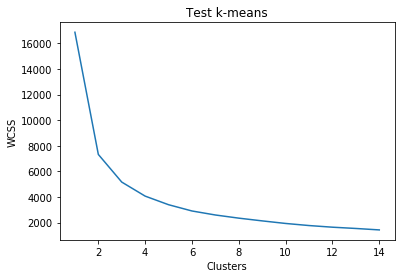

In [56]:
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show

<function matplotlib.pyplot.show>

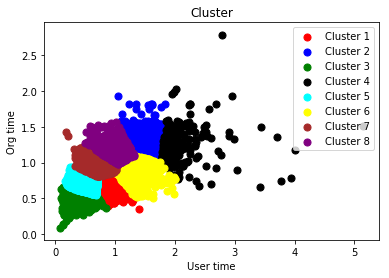

In [59]:
kmeans = KMeans(n_clusters =8, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
X=Tab.loc[:,['Normalized Req user','Normalized Req user org']].values

plt.scatter(X[y_kmeans ==0,0],X[y_kmeans ==0,1],s=50,c='red',label ='Cluster 1')
plt.scatter(X[y_kmeans ==1,0],X[y_kmeans ==1,1],s=50,c='blue',label ='Cluster 2')
plt.scatter(X[y_kmeans ==2,0],X[y_kmeans ==2,1],s=50,c='green',label ='Cluster 3')
plt.scatter(X[y_kmeans ==3,0],X[y_kmeans ==3,1],s=50,c='black',label ='Cluster 4')
plt.scatter(X[y_kmeans ==4,0],X[y_kmeans ==4,1],s=50,c='cyan',label ='Cluster 5')
plt.scatter(X[y_kmeans ==5,0],X[y_kmeans ==5,1],s=50,c='yellow',label ='Cluster 6')
plt.scatter(X[y_kmeans ==6,0],X[y_kmeans ==6,1],s=50,c='brown',label ='Cluster 7')
plt.scatter(X[y_kmeans ==7,0],X[y_kmeans ==7,1],s=50,c='purple',label ='Cluster 8')

plt.title('Cluster')
plt.xlabel('User time')
plt.ylabel('Org time')
plt.legend()
plt.show

In [ ]:
## Linear regression, add concurrency, 

## Adding Concurrency to the org file
I will try to include concurrency to the org file to try to estimate the duration of a request given the concurrency


In [7]:
Events_proc=pandas.read_csv('data_orgid.csv')
Events_proc=Events_proc.drop_duplicates(subset=['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP'])
Events_proc['StartTime']=Events_proc['StartTime'].apply(transfo_date_delay)
Events_proc['EndTime']=Events_proc['EndTime'].apply(transfo_date_delay)
Events_proc['ServerIP']=Events_proc['ServerIP'].apply(server_translate)


In [8]:
Server1=Events_proc.loc[Events_proc['ServerIP']=='nxp1',:]
Server1=Server1.sort_values(by='StartTime')
Server1=Server1.drop_duplicates()
X=Server1.loc[:,['StartTime','EndTime']].values
a=X.shape[0]
l=np.zeros(a)
for i in tqdm(range (a)):
    comp=0
    for j in range (i,min(a,i+25)):
        if (X[j][0]>=X[i][0] and X[j][0]<=X[i][1]) or (X[j][1]>=X[i][0] and X[j][1]<=X[i][1]):
            comp+=1
            l[j]+=1
    l[i]=comp
    if comp>20 :
        print('Error for request number {1}, compt number is {2}',i,comp)
Server1['Concurrency']=l
Server1.to_csv('concurrency_org.csv')

 95%|█████████▌| 44788/46944 [00:48<00:02, 931.43it/s]

Error for request number {1}, compt number is {2} 44844 25


100%|██████████| 46944/46944 [00:50<00:00, 932.35it/s]


In [9]:
c=np.array([
        ['nxp2', '172.27.8.45'],
        ['nxp3','172.27.8.82'],
        ['nxp4' ,'172.27.8.84'],
        ['nxp5' ,'172.27.8.85'],
        ['nxp6' ,'172.27.8.86'],
        ['nxp7' ,'172.27.8.87'],
        ['nxp8' ,'172.27.8.90'],
        ['nxp9' ,'172.27.8.91'],
        ['nxp10' ,'172.27.8.93'],
        ['nxp11' ,'172.27.8.47'],
        ['nxp12' ,'172.27.8.49'],
        ['nxp13' ,'172.27.8.46']])
liste=c[:,0]
Tab=pandas.read_csv('concurrency_org.csv')
anomalies=[]
for serv in liste :
    Server=Events_proc.loc[Events_proc['ServerIP']==serv,:]
    Server=Server.sort_values(by='StartTime')
    Server=Server.drop_duplicates()
    X=Server.loc[:,['StartTime','EndTime']].values
    a=X.shape[0]
    l=np.zeros(a)
    for i in tqdm(range (a)):
        comp=0
        for j in range (i,min(a,i+100)):
            if (X[j][0]>=X[i][0] and X[j][0]<=X[i][1]) or (X[j][1]>=X[i][0] and X[j][1]<=X[i][1]):
                comp+=1
                l[j]+=1
        l[i]+=comp
        if l[i]>90 :
            print('Error for request number {1}, compt number is {2}',i,l[i])
            anomalies.append([serv,X[0],X[1],l[i]])
    Server['Concurrency']=l
    Tab=pandas.concat([Tab,Server])
    Tab.to_csv('Concurrencies_org.csv')

 27%|██▋       | 12186/44769 [00:56<02:30, 216.19it/s]

Error for request number {1}, compt number is {2} 12196 91.0
Error for request number {1}, compt number is {2} 12197 94.0
Error for request number {1}, compt number is {2} 12198 93.0
Error for request number {1}, compt number is {2} 12199 95.0
Error for request number {1}, compt number is {2} 12200 96.0
Error for request number {1}, compt number is {2} 12201 98.0
Error for request number {1}, compt number is {2} 12202 100.0
Error for request number {1}, compt number is {2} 12203 99.0
Error for request number {1}, compt number is {2} 12204 99.0
Error for request number {1}, compt number is {2} 12206 100.0
Error for request number {1}, compt number is {2} 12207 104.0
Error for request number {1}, compt number is {2} 12208 107.0
Error for request number {1}, compt number is {2} 12209 109.0
Error for request number {1}, compt number is {2} 12210 110.0
Error for request number {1}, compt number is {2} 12211 109.0


 27%|██▋       | 12212/44769 [00:56<02:31, 215.52it/s]

Error for request number {1}, compt number is {2} 12212 109.0
Error for request number {1}, compt number is {2} 12213 110.0
Error for request number {1}, compt number is {2} 12214 110.0
Error for request number {1}, compt number is {2} 12215 113.0
Error for request number {1}, compt number is {2} 12216 116.0
Error for request number {1}, compt number is {2} 12217 117.0
Error for request number {1}, compt number is {2} 12218 119.0
Error for request number {1}, compt number is {2} 12219 120.0
Error for request number {1}, compt number is {2} 12220 121.0
Error for request number {1}, compt number is {2} 12221 125.0
Error for request number {1}, compt number is {2} 12222 129.0
Error for request number {1}, compt number is {2} 12223 130.0
Error for request number {1}, compt number is {2} 12224 133.0
Error for request number {1}, compt number is {2} 12225 134.0
Error for request number {1}, compt number is {2} 12226 138.0
Error for request number {1}, compt number is {2} 12227 136.0
Error fo

 27%|██▋       | 12233/44769 [00:57<02:31, 214.52it/s]

Error for request number {1}, compt number is {2} 12233 136.0
Error for request number {1}, compt number is {2} 12234 136.0
Error for request number {1}, compt number is {2} 12235 136.0
Error for request number {1}, compt number is {2} 12236 135.0
Error for request number {1}, compt number is {2} 12237 135.0
Error for request number {1}, compt number is {2} 12241 130.0
Error for request number {1}, compt number is {2} 12242 129.0
Error for request number {1}, compt number is {2} 12244 128.0
Error for request number {1}, compt number is {2} 12245 128.0
Error for request number {1}, compt number is {2} 12246 128.0
Error for request number {1}, compt number is {2} 12248 128.0
Error for request number {1}, compt number is {2} 12249 126.0


 27%|██▋       | 12250/44769 [00:57<02:31, 213.96it/s]

Error for request number {1}, compt number is {2} 12250 126.0
Error for request number {1}, compt number is {2} 12252 123.0
Error for request number {1}, compt number is {2} 12253 123.0
Error for request number {1}, compt number is {2} 12254 122.0
Error for request number {1}, compt number is {2} 12255 122.0
Error for request number {1}, compt number is {2} 12256 122.0
Error for request number {1}, compt number is {2} 12257 123.0
Error for request number {1}, compt number is {2} 12258 125.0
Error for request number {1}, compt number is {2} 12259 125.0
Error for request number {1}, compt number is {2} 12260 125.0
Error for request number {1}, compt number is {2} 12261 126.0
Error for request number {1}, compt number is {2} 12262 126.0
Error for request number {1}, compt number is {2} 12263 126.0


 27%|██▋       | 12264/44769 [00:57<02:32, 213.26it/s]

Error for request number {1}, compt number is {2} 12264 126.0
Error for request number {1}, compt number is {2} 12265 127.0
Error for request number {1}, compt number is {2} 12266 127.0
Error for request number {1}, compt number is {2} 12267 128.0
Error for request number {1}, compt number is {2} 12268 127.0
Error for request number {1}, compt number is {2} 12269 128.0
Error for request number {1}, compt number is {2} 12270 129.0
Error for request number {1}, compt number is {2} 12271 137.0
Error for request number {1}, compt number is {2} 12272 138.0
Error for request number {1}, compt number is {2} 12273 139.0
Error for request number {1}, compt number is {2} 12274 138.0
Error for request number {1}, compt number is {2} 12275 138.0


 27%|██▋       | 12276/44769 [00:57<02:32, 212.76it/s]

Error for request number {1}, compt number is {2} 12276 142.0
Error for request number {1}, compt number is {2} 12277 142.0
Error for request number {1}, compt number is {2} 12278 141.0
Error for request number {1}, compt number is {2} 12279 141.0
Error for request number {1}, compt number is {2} 12280 141.0
Error for request number {1}, compt number is {2} 12281 141.0
Error for request number {1}, compt number is {2} 12282 138.0
Error for request number {1}, compt number is {2} 12283 137.0
Error for request number {1}, compt number is {2} 12284 137.0
Error for request number {1}, compt number is {2} 12285 139.0


 27%|██▋       | 12286/44769 [00:57<02:33, 212.30it/s]

Error for request number {1}, compt number is {2} 12286 139.0
Error for request number {1}, compt number is {2} 12287 140.0
Error for request number {1}, compt number is {2} 12288 140.0
Error for request number {1}, compt number is {2} 12289 140.0
Error for request number {1}, compt number is {2} 12290 140.0
Error for request number {1}, compt number is {2} 12291 140.0
Error for request number {1}, compt number is {2} 12292 139.0
Error for request number {1}, compt number is {2} 12293 139.0
Error for request number {1}, compt number is {2} 12294 138.0


 27%|██▋       | 12295/44769 [00:58<02:33, 211.88it/s]

Error for request number {1}, compt number is {2} 12295 137.0
Error for request number {1}, compt number is {2} 12296 137.0
Error for request number {1}, compt number is {2} 12297 136.0
Error for request number {1}, compt number is {2} 12299 136.0
Error for request number {1}, compt number is {2} 12300 136.0
Error for request number {1}, compt number is {2} 12302 133.0


 27%|██▋       | 12303/44769 [00:58<02:34, 210.76it/s]

Error for request number {1}, compt number is {2} 12304 132.0
Error for request number {1}, compt number is {2} 12305 132.0
Error for request number {1}, compt number is {2} 12306 131.0
Error for request number {1}, compt number is {2} 12307 131.0
Error for request number {1}, compt number is {2} 12308 130.0
Error for request number {1}, compt number is {2} 12309 130.0


 27%|██▋       | 12310/44769 [00:58<02:34, 210.41it/s]

Error for request number {1}, compt number is {2} 12310 130.0
Error for request number {1}, compt number is {2} 12311 129.0
Error for request number {1}, compt number is {2} 12312 130.0
Error for request number {1}, compt number is {2} 12313 129.0
Error for request number {1}, compt number is {2} 12315 128.0


 28%|██▊       | 12316/44769 [00:58<02:34, 210.11it/s]

Error for request number {1}, compt number is {2} 12316 128.0
Error for request number {1}, compt number is {2} 12318 127.0


 30%|███       | 13228/43993 [01:03<02:27, 208.22it/s]

Error for request number {1}, compt number is {2} 13238 92.0
Error for request number {1}, compt number is {2} 13239 91.0
Error for request number {1}, compt number is {2} 13242 93.0
Error for request number {1}, compt number is {2} 13243 95.0
Error for request number {1}, compt number is {2} 13244 99.0
Error for request number {1}, compt number is {2} 13245 99.0
Error for request number {1}, compt number is {2} 13247 101.0


 30%|███       | 13250/43993 [01:03<02:27, 207.84it/s]

Error for request number {1}, compt number is {2} 13250 99.0
Error for request number {1}, compt number is {2} 13251 98.0
Error for request number {1}, compt number is {2} 13252 100.0
Error for request number {1}, compt number is {2} 13253 103.0
Error for request number {1}, compt number is {2} 13255 106.0
Error for request number {1}, compt number is {2} 13256 108.0
Error for request number {1}, compt number is {2} 13257 108.0
Error for request number {1}, compt number is {2} 13258 110.0
Error for request number {1}, compt number is {2} 13259 114.0
Error for request number {1}, compt number is {2} 13261 113.0
Error for request number {1}, compt number is {2} 13262 113.0
Error for request number {1}, compt number is {2} 13264 110.0
Error for request number {1}, compt number is {2} 13265 110.0
Error for request number {1}, compt number is {2} 13266 110.0
Error for request number {1}, compt number is {2} 13267 110.0
Error for request number {1}, compt number is {2} 13268 111.0


 30%|███       | 13269/43993 [01:04<02:28, 207.01it/s]

Error for request number {1}, compt number is {2} 13269 113.0
Error for request number {1}, compt number is {2} 13270 118.0
Error for request number {1}, compt number is {2} 13271 120.0
Error for request number {1}, compt number is {2} 13272 121.0
Error for request number {1}, compt number is {2} 13273 123.0
Error for request number {1}, compt number is {2} 13274 125.0
Error for request number {1}, compt number is {2} 13275 125.0
Error for request number {1}, compt number is {2} 13277 128.0
Error for request number {1}, compt number is {2} 13278 130.0
Error for request number {1}, compt number is {2} 13279 131.0
Error for request number {1}, compt number is {2} 13282 133.0


 30%|███       | 13284/43993 [01:04<02:28, 206.41it/s]

Error for request number {1}, compt number is {2} 13284 136.0
Error for request number {1}, compt number is {2} 13285 140.0
Error for request number {1}, compt number is {2} 13287 140.0
Error for request number {1}, compt number is {2} 13288 141.0
Error for request number {1}, compt number is {2} 13290 142.0
Error for request number {1}, compt number is {2} 13291 143.0
Error for request number {1}, compt number is {2} 13293 143.0


 30%|███       | 13296/43993 [01:04<02:28, 206.10it/s]

Error for request number {1}, compt number is {2} 13296 141.0
Error for request number {1}, compt number is {2} 13299 140.0
Error for request number {1}, compt number is {2} 13302 141.0
Error for request number {1}, compt number is {2} 13303 141.0
Error for request number {1}, compt number is {2} 13304 142.0
Error for request number {1}, compt number is {2} 13305 141.0


 30%|███       | 13307/43993 [01:04<02:29, 205.83it/s]

Error for request number {1}, compt number is {2} 13307 143.0
Error for request number {1}, compt number is {2} 13309 140.0
Error for request number {1}, compt number is {2} 13310 140.0
Error for request number {1}, compt number is {2} 13311 141.0
Error for request number {1}, compt number is {2} 13312 140.0
Error for request number {1}, compt number is {2} 13313 142.0
Error for request number {1}, compt number is {2} 13314 142.0
Error for request number {1}, compt number is {2} 13315 142.0


 30%|███       | 13317/43993 [01:04<02:29, 205.37it/s]

Error for request number {1}, compt number is {2} 13317 141.0
Error for request number {1}, compt number is {2} 13318 140.0
Error for request number {1}, compt number is {2} 13320 140.0
Error for request number {1}, compt number is {2} 13321 139.0
Error for request number {1}, compt number is {2} 13322 139.0
Error for request number {1}, compt number is {2} 13323 139.0
Error for request number {1}, compt number is {2} 13324 140.0
Error for request number {1}, compt number is {2} 13325 139.0


 30%|███       | 13326/43993 [01:04<02:29, 205.04it/s]

Error for request number {1}, compt number is {2} 13326 140.0
Error for request number {1}, compt number is {2} 13327 140.0
Error for request number {1}, compt number is {2} 13328 140.0
Error for request number {1}, compt number is {2} 13329 139.0
Error for request number {1}, compt number is {2} 13330 139.0
Error for request number {1}, compt number is {2} 13331 138.0
Error for request number {1}, compt number is {2} 13332 138.0
Error for request number {1}, compt number is {2} 13333 138.0


 30%|███       | 13334/43993 [01:05<02:29, 204.69it/s]

Error for request number {1}, compt number is {2} 13334 140.0
Error for request number {1}, compt number is {2} 13336 135.0
Error for request number {1}, compt number is {2} 13337 135.0
Error for request number {1}, compt number is {2} 13338 133.0
Error for request number {1}, compt number is {2} 13340 132.0


 30%|███       | 13341/43993 [01:05<02:29, 204.42it/s]

Error for request number {1}, compt number is {2} 13341 132.0
Error for request number {1}, compt number is {2} 13345 129.0
Error for request number {1}, compt number is {2} 13346 128.0
Error for request number {1}, compt number is {2} 13347 128.0
Error for request number {1}, compt number is {2} 13348 127.0


 30%|███       | 13349/43993 [01:05<02:30, 204.20it/s]

Error for request number {1}, compt number is {2} 13349 128.0
Error for request number {1}, compt number is {2} 13350 130.0
Error for request number {1}, compt number is {2} 13352 130.0
Error for request number {1}, compt number is {2} 13354 131.0
Error for request number {1}, compt number is {2} 13355 132.0


 30%|███       | 13356/43993 [01:05<02:30, 203.92it/s]

Error for request number {1}, compt number is {2} 13356 132.0
Error for request number {1}, compt number is {2} 13359 129.0
Error for request number {1}, compt number is {2} 13361 129.0
Error for request number {1}, compt number is {2} 13364 127.0


 30%|███       | 13365/43993 [01:05<02:30, 203.71it/s]

Error for request number {1}, compt number is {2} 13365 125.0
Error for request number {1}, compt number is {2} 13367 123.0
Error for request number {1}, compt number is {2} 13368 123.0
Error for request number {1}, compt number is {2} 13369 123.0
Error for request number {1}, compt number is {2} 13370 123.0
Error for request number {1}, compt number is {2} 13371 123.0


 30%|███       | 13372/43993 [01:05<02:30, 202.89it/s]

Error for request number {1}, compt number is {2} 13372 122.0
Error for request number {1}, compt number is {2} 13373 123.0
Error for request number {1}, compt number is {2} 13374 123.0
Error for request number {1}, compt number is {2} 13375 122.0
Error for request number {1}, compt number is {2} 13376 122.0


 30%|███       | 13378/43993 [01:06<02:31, 202.62it/s]

Error for request number {1}, compt number is {2} 13378 122.0
Error for request number {1}, compt number is {2} 13379 121.0
Error for request number {1}, compt number is {2} 13381 119.0
Error for request number {1}, compt number is {2} 13385 116.0
Error for request number {1}, compt number is {2} 13386 117.0


 30%|███       | 13387/43993 [01:06<02:31, 202.43it/s]

Error for request number {1}, compt number is {2} 13388 115.0
Error for request number {1}, compt number is {2} 13390 112.0
Error for request number {1}, compt number is {2} 13392 111.0
Error for request number {1}, compt number is {2} 13394 109.0


 30%|███       | 13395/43993 [01:06<02:31, 202.23it/s]

Error for request number {1}, compt number is {2} 13395 109.0
Error for request number {1}, compt number is {2} 13396 108.0
Error for request number {1}, compt number is {2} 13398 107.0
Error for request number {1}, compt number is {2} 13399 106.0
Error for request number {1}, compt number is {2} 13400 106.0


 23%|██▎       | 10788/46733 [00:50<02:47, 214.75it/s]

Error for request number {1}, compt number is {2} 10807 101.0


100%|██████████| 43532/43532 [03:37<00:00, 199.99it/s]


In [ ]:
## Plot the requests elapsed(normalized) with concurrency to see if we have a shape
# Check Server 4

In [17]:
Concurrencies_req=pandas.read_csv('Concurrencies_org.csv')
Req_mean=Concurrencies_req[['EventID','Elapsed']]
Req_mean=Req_mean.groupby(by='EventID').max()
Req_mean.columns=['Mean time']
Con_req=Concurrencies_req[['EventID','Elapsed','Concurrency']]
Con_req=Con_req.merge(Req_mean,how='inner',left_on='EventID',right_index=True)
col=Con_req.apply(lambda row : row['Elapsed']/row['Mean time'], axis=1)
Con_req['Normalized time'] = col



<function matplotlib.pyplot.show>

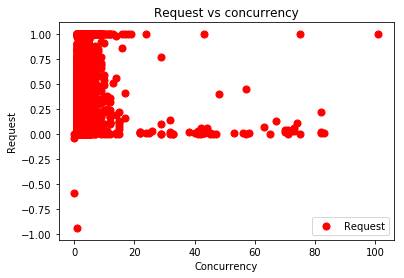

In [18]:
plt.scatter(Con_req['Concurrency'],Con_req['Normalized time'],s=50,c='red',label ='Request')
plt.title('Request vs concurrency')
plt.xlabel('Concurrency')
plt.ylabel('Request')
plt.legend()
plt.show

In [36]:
AAA=Concurrencies_req[['EventID']]
AAA=AAA.drop_duplicates()
print(AAA.shape)
lis=AAA.values
liste=lis[:,0]
l=[]
#print(liste)
for i in liste:
    Tab=Concurrencies_req.loc[Concurrencies_req['EventID']==i,:]
    l.append(Tab.shape[0])
AAA['NBR']=l
AAA=AAA.sort_values(by='NBR',ascending=False)

(466, 1)


In [37]:
print(AAA.head())

       EventID    NBR
64  BkTdY1qSc6  51483
28    uDpb9dAO  25637
19    uBBaQgfD  12374
26    wIt50agH  11903
29    uQjsCM4b  11733


In [42]:
BBB=AAA.head(n=10)
liste=BBB['EventID'].values

        EventID    NBR
64   BkTdY1qSc6  51483
28     uDpb9dAO  25637
19     uBBaQgfD  12374
26     wIt50agH  11903
29     uQjsCM4b  11733
1      uGv5Zj5l   8134
2      uM6VbDSi   7266
432    uDphDdvt   5750
447   x84sljJ1H   3911
888   x84sljJ1J   2100
['BkTdY1qSc6' 'uDpb9dAO' 'uBBaQgfD' 'wIt50agH' 'uQjsCM4b' 'uGv5Zj5l'
 'uM6VbDSi' 'uDphDdvt' 'x84sljJ1H' 'x84sljJ1J']


In [54]:
Conc_req=Concurrencies_req.loc[Concurrencies_req['Elapsed']<5000,['EventID','Concurrency','Elapsed']]
for i in liste :
    DF_int=Conc_req.loc[Conc_req['EventID']==i,:]
    DF_int2=DF_int[['Concurrency','Elapsed']]
    DF_int2=DF_int2.groupby(by=['Concurrency']).mean()
    plt.scatter(DF_int2.index.values,DF_int2['Elapsed'],s=50,c='red',label ='Request')
    plt.title('Request vs concurrency')
    plt.xlabel('Concurrency')
    plt.ylabel('Request')
    plt.legend()
    plt.show
    plt.savefig('testplot'+i+'.png')
    plt.clf()
    

In [ ]:
### possibility to go request by request to exclude the mean step


## Analyzing the org usage

<function matplotlib.pyplot.show>

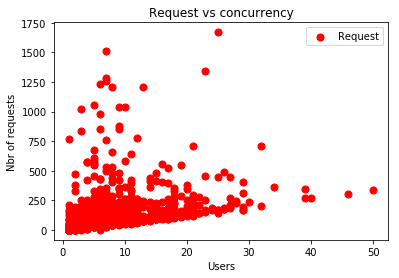

In [13]:
Data=pandas.read_csv('concurrencies_org.csv')
Tab=Data[['Concurrency','OrgID','EventID','Elapsed','UserID']]

Usage=Tab[['OrgID','EventID']]
Usage=Usage.groupby(by='OrgID').count()

Users=Tab[['OrgID','UserID']]
Users=Users.drop_duplicates()
Users=Users.groupby(by='OrgID').count()

Usage=Usage.merge(Users, right_index=True, left_index=True, how='inner')
Usage=Usage.loc[Usage['EventID']<2000,:]
plt.scatter(Usage['UserID'],Usage['EventID'],s=50,c='red',label ='Request')
plt.title('Request vs concurrency')
plt.xlabel('Users')
plt.ylabel('Nbr of requests')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

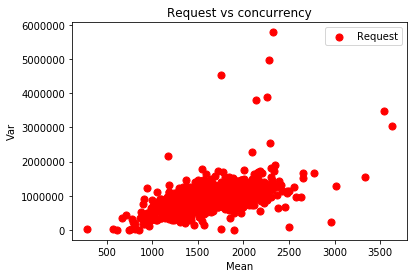

In [15]:
Usage2=Tab[['OrgID','Elapsed']]
Usage2=Usage2.loc[Usage2['Elapsed']<5000,:]
Var=Usage2.groupby(by='OrgID').var()
Res1=Var.merge(Users,right_index=True,left_index=True)
Mean=Usage2.groupby(by='OrgID').mean()
Mean.columns=['Mean']
Res2=Mean.merge(Var,right_index=True,left_index=True)
Res2=Res2.loc[Res2['Elapsed']<10000000,:]
Res2=Res2.loc[Res2['Mean']<20000,:]
plt.scatter(Res2['Mean'],Res2['Elapsed'],s=50,c='red',label ='Request')
plt.title('Request vs concurrency')
plt.xlabel('Mean')
plt.ylabel('Var')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

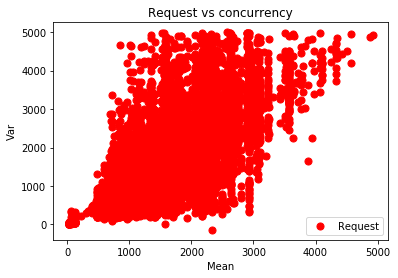

In [27]:
Req_org=Data[['EventID','OrgID','Elapsed']]
Req_org=Req_org.loc[Req_org['Elapsed']<5000]
Req_org=Req_org.groupby(by=['OrgID','EventID']).mean()

Req_org.to_csv('a.csv')
Req_org=pandas.read_csv('a.csv')
Req_org.columns=['OrgID','EventID','Elapsed org']

Req_org2=Data[['EventID','Elapsed']]
Req_org2=Req_org2.loc[Req_org2['Elapsed']<5000]
Req_org2=Req_org2.groupby(by='EventID').mean()

Req_org2.columns=['Elapsed glob']


Res=Req_org.merge(Req_org2, right_index=True, left_on='EventID')
plt.scatter(Res['Elapsed glob'],Res['Elapsed org'],s=50,c='red',label ='Request')
plt.title('Request vs concurrency')
plt.xlabel('Mean')
plt.ylabel('Var')
plt.legend()
plt.show

In [24]:
Data=pandas.read_csv('concurrencies_org.csv')
Data['StartTime']=Data['StartTime'].apply(transfo_date)
Tab=Data[['Elapsed','UserID','EventID','EntryID','SessionID','StartTime','WorkspaceID']]


In [30]:
#Tab['StartTime']=Tab['StartTime'].apply(transfo_date)
Tab['Day']=Tab['StartTime'].apply(troncat_date)
col=Tab.apply( lambda row : (row['StartTime']-row['Day']).total_seconds(), axis=1 )
Tab['Hour']=col



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<function matplotlib.pyplot.show>

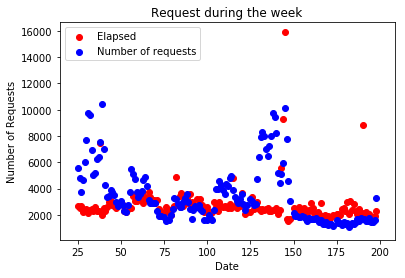

In [36]:

Tab2=Data[['Elapsed','UserID','EventID','EntryID','SessionID','StartTime','WorkspaceID']]
Tab2['Sched']=Tab2['StartTime'].apply(troncat_hour_week)
Tab2_int=Tab2[['SessionID','Sched']]
Tab2_int=Tab2_int.groupby(by='Sched').count()
Tab3_int=Tab2[['Elapsed','Sched']]
Tab3_int=Tab3_int.groupby(by='Sched').mean()
plt.scatter(Tab3_int.index,Tab3_int['Elapsed'],c='red',label='Elapsed')
plt.scatter(Tab2_int.index,Tab2_int['SessionID'],c='blue',label='Number of requests')
plt.title('Request during the week')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

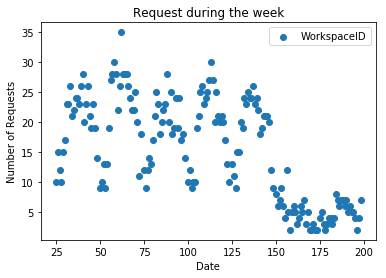

In [41]:

Tab3_int=Tab2[['WorkspaceID','Sched']]
Tab3_int=Tab3_int.drop_duplicates()
Tab3_int=Tab3_int.groupby(by='Sched').count()
plt.scatter(Tab3_int.index,Tab3_int['WorkspaceID'])
plt.title('Request during the week')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.show

In [52]:
## Same results for the best orgs
Tab=Data[['OrgID','StartTime','SessionID']]
Tab_int=Tab.groupby(by='OrgID').count()
Tab_int=Tab_int.sort_values(by='SessionID',ascending=False)
liste=Tab_int.iloc[:10,1]
liste=liste.index.values
Tab['Sched']=Tab['StartTime'].apply(troncat_hour_week)
print(Tab)
for i in liste :
    #print(i)
    Tab3_int=Tab.loc[Tab['OrgID']==i,['Sched','SessionID']]
    Tab3_int=Tab3_int.groupby(by='Sched').count()
    plt.scatter(Tab3_int.index,Tab3_int['SessionID'])
    plt.title('Request during the week')
    plt.xlabel('Date')
    plt.ylabel('Number of Requests')
    plt.legend()
    plt.savefig('Org '+str(i)+'.png')
    plt.clf()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


           OrgID               StartTime  SessionID  Sched
0          55251 2018-02-26 20:55:52.939    3379245     45
1          55251 2018-02-26 20:56:00.364    3379245     45
2          55251 2018-02-26 20:56:06.802    3379245     45
3          55251 2018-02-26 20:56:09.033    3379245     45
4        3908309 2018-02-26 20:56:26.545    3379248     45
5        3908309 2018-02-26 20:56:34.223    3379248     45
6              1 2018-02-26 21:01:11.590    3379277     46
7              1 2018-02-26 21:01:12.972    3379278     46
8              1 2018-02-26 21:01:26.951    3379280     46
9              1 2018-02-26 21:01:30.146    3379280     46
10             1 2018-02-26 21:01:31.912    3379282     46
11             1 2018-02-26 21:01:41.902    3379282     46
12       3908309 2018-02-26 21:06:40.655    3379307     46
13       3908309 2018-02-26 21:07:11.389    3379307     46
14       3908309 2018-02-26 21:07:21.684    3379307     46
15      35628896 2018-02-26 21:07:32.190    3379311     

In [ ]:
# Voir le fichier sur cle + 

## Extracting the moment of the max number of requests

In [43]:
M=Data['Concurrency'].idxmax()
print(M)
#Data['StartTime']=Data['StartTime'].apply(transfo_date)
Date=Data.loc[M,'StartTime']
print(Date)
heure=datetime.timedelta(hours=1)
tplus=Date+heure
tmoins=Date-heure
Surcharge=Data.loc[Data['StartTime']>tmoins,:]
Surcharge=Surcharge.loc[Surcharge['StartTime']<tplus,:]
Surcharge.to_excel('Surcharge.xlsx')

280628
2018-03-09 20:04:32.748000


In [49]:
M=Data['Concurrency'].idxmax()
tplus=Date+heure
tmoins=Date-heure
Surchargev2=Data.loc[Data['StartTime']<tmoins,:]
Surchargev3=Data.loc[Data['StartTime']>tplus,:]
Surchargev2=pandas.concat([Surchargev2,Surchargev3])
Mv2=Surchargev2['Concurrency'].idxmax()

Date2=Data.loc[Mv2,'StartTime']
tplus2=Date2+heure
tmoins2=Date2-heure
Surcharge=Surchargev2.loc[Surchargev2['StartTime']>tmoins2,:]
Surcharge=Surcharge.loc[Surchargev2['StartTime']<tplus2,:]
Surcharge.to_excel('Surcharge2.xlsx')

In [5]:
Data=pandas.read_csv('concurrencies_org.csv')
Tab=Data[['UserID','Elapsed','Concurrency','EventID']]
liste_req=['x84sljJ14',
'uGv5Zj5l',
'uM6VbDSi',
'x84slQln',
'BkTdY1qSc6',
'BkTdY1Y0UI',
'uBBaQgfD',
'BkTdY1qLh4',
'BkTdY1Y0UG',
'wIt50agH',
'BkTdY1Y0UJ',
'uDpb9dAO',
'uQjsCM4b',
'x84sljJ1J',
'x84sljJzv',
'uDphDdvt',
'uGv5ZhaJ',
'wBrdE6u3',
'x84sljJ1k',
'BkTdY1qyfl',
'x84sljJ1H',
'Bdx0h1112U']

liste_use=[9611416,
11066941,
63693,
56603,
60608,
9623476,
8798811,
57040,
3179155,
62347,
2931137,
3179556,
61606,
57082,
8837196,
101716,
18977329,
62745,
101718,
9519408,
63821,
59568,
20923534,
9485950,
9610289,
59148,
57033,
9487759,
63536,
58869,
60995,
63460,
63454]

Res=Tab.head(n=1)
Res2=Tab.head(n=1)
for i in tqdm(liste_req) :
    Tab_int=Tab.loc[Tab['EventID']==i,:]
    Res=pandas.concat([Res,Tab_int])
for j in tqdm(liste_use) : 
    Tab_int=Res.loc[Res['UserID']==j,:]
    Res2=pandas.concat([Res2,Tab_int])
    
Res2.to_csv('Elapsed_conc_analysis.csv')

100%|██████████| 33/33 [00:00<00:00, 170.10it/s]


In [12]:
Res3=Res2.loc[Res2['Concurrency']<5,:]
Res4=Res2.loc[Res2['Concurrency']>=5,:]
Res3=Res3.groupby(by=['UserID','EventID']).median()
Res3.to_csv('aaa.csv')
Res3=pandas.read_csv('aaa.csv')
Res5=Res3.merge(Res4, on=['UserID','EventID'], how='left')
Res5.to_csv('BbBb.csv')

<function matplotlib.pyplot.show>

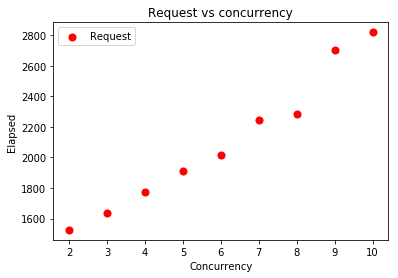

In [39]:
Tab_mp=pandas.read_csv('Concrrencies_allservers.csv')
Tab_mp=Tab_mp.loc[Tab_mp['EventID']=='uQjsCM4b',:]
Tab_mp2=Tab_mp[['Elapsed','Concurrency']]
M=Tab_mp['Concurrency'].idxmax()
#Tab_mp=Tab_mp.loc[Tab_mp['Elapsed']<20000,:]
#Tab_mp=Tab_mp.loc[Tab_mp['Concurrency']<10,:]
Tab_mp2=Tab_mp2.loc[Tab_mp2['Elapsed']<5000,:]
Tab_mp3=Tab_mp2.groupby(by='Concurrency').mean()
Tab_mp4=Tab_mp2.groupby(by='Concurrency').count()
Tab_mp4.columns=['Count req']
Tab_mp2=Tab_mp3.merge(Tab_mp4,left_index=True,right_index=True)
Tab_mp2=Tab_mp2.loc[Tab_mp2['Count req']>10]
plt.scatter(Tab_mp2.index,Tab_mp2['Elapsed'],s=50,c='red',label ='Request')
plt.title('Request vs concurrency')
plt.xlabel('Concurrency')
plt.ylabel('Elapsed')
plt.legend()
plt.show

## Separating the pre 24th January and the post 24th

In [44]:
Tab_mp_or=pandas.read_csv('Concrrencies_allservers.csv')
Tab_mp_or['StartTime']=Tab_mp_or['StartTime'].apply(transfo_date)

### Extracting the most used requests

In [18]:
Mostused=Tab_mp_or[['EventID','SessionID']]
Mostused=Mostused.groupby(by='EventID').count()
Mostused=Mostused.sort_values(by='SessionID',ascending=False)
list_req=Mostused.iloc[:10,0]
list_req=list_req.index.values
print(list_req)

['BkTdY1qSc6' 'uDpb9dAO' 'uBBaQgfD' 'uQjsCM4b' 'wIt50agH' 'uGv5Zj5l'
 'uM6VbDSi' 'uDphDdvt' 'x84sljJ1H' 'x84sljJ1J']


<function matplotlib.pyplot.show>

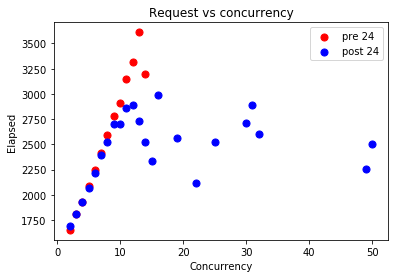

In [10]:
Tab_mp_or=pandas.read_csv('Concrrencies_allservers.csv')
#Tab_mp_or=pandas.read_csv('Total concurrenciesv2.csv')
Tab_mp_or['StartTime']=Tab_mp_or['StartTime'].apply(transfo_date)
Date_shift=datetime.datetime(year=2018,month=1,day=24,hour=0,minute=0,second=0)


Tab_mp=Tab_mp_or.loc[Tab_mp_or['StartTime']<Date_shift]
#Tab_mp=Tab_mp.loc[Tab_mp['EventID']=='uQjsCM4b',:]
Tab_mp2=Tab_mp[['Elapsed','Concurrency']]
M=Tab_mp['Concurrency'].idxmax()
#Tab_mp=Tab_mp.loc[Tab_mp['Elapsed']<20000,:]
#Tab_mp=Tab_mp.loc[Tab_mp['Concurrency']<10,:]
Tab_mp2=Tab_mp2.loc[Tab_mp2['Elapsed']<5000,:]
Tab_mp3=Tab_mp2.groupby(by='Concurrency').mean()
Tab_mp4=Tab_mp2.groupby(by='Concurrency').count()
Tab_mp4.columns=['Count req']
Tab_mp2=Tab_mp3.merge(Tab_mp4,left_index=True,right_index=True)
Tab_mp2=Tab_mp2.loc[Tab_mp2['Count req']>10]

JTab_mp=Tab_mp_or.loc[Tab_mp_or['StartTime']>Date_shift]
#JTab_mp=JTab_mp.loc[JTab_mp['EventID']=='uQjsCM4b',:]
JTab_mp2=JTab_mp[['Elapsed','Concurrency']]

#Tab_mp=Tab_mp.loc[Tab_mp['Elapsed']<20000,:]
#Tab_mp=Tab_mp.loc[Tab_mp['Concurrency']<10,:]
JTab_mp2=JTab_mp2.loc[JTab_mp2['Elapsed']<5000,:]
JTab_mp3=JTab_mp2.groupby(by='Concurrency').mean()
JTab_mp4=JTab_mp2.groupby(by='Concurrency').count()
JTab_mp4.columns=['Count req']
JTab_mp2=JTab_mp3.merge(JTab_mp4,left_index=True,right_index=True)
JTab_mp2=JTab_mp2.loc[JTab_mp2['Count req']>25]
plt.scatter(Tab_mp2.index,Tab_mp2['Elapsed'],s=50,c='red',label ='pre 24')
plt.scatter(JTab_mp2.index,JTab_mp2['Elapsed'],s=50,c='blue',label ='post 24')
plt.title('Request vs concurrency')
plt.xlabel('Concurrency')
plt.ylabel('Elapsed')
plt.legend()
plt.show

In [19]:
for i in tqdm(list_req) :
    Tab_mp=Tab_mp_or.loc[Tab_mp_or['StartTime']<Date_shift]
    Tab_mp=Tab_mp.loc[Tab_mp['EventID']==i,:]
    Tab_mp2=Tab_mp[['Elapsed','Concurrency']]
#Tab_mp=Tab_mp.loc[Tab_mp['Elapsed']<20000,:]
#Tab_mp=Tab_mp.loc[Tab_mp['Concurrency']<10,:]
    Tab_mp2=Tab_mp2.loc[Tab_mp2['Elapsed']<5000,:]
    Tab_mp3=Tab_mp2.groupby(by='Concurrency').mean()
    Tab_mp4=Tab_mp2.groupby(by='Concurrency').count()
    Tab_mp4.columns=['Count req']
    Tab_mp2=Tab_mp3.merge(Tab_mp4,left_index=True,right_index=True)
    Tab_mp2=Tab_mp2.loc[Tab_mp2['Count req']>10]

    JTab_mp=Tab_mp_or.loc[Tab_mp_or['StartTime']>Date_shift]
    JTab_mp=JTab_mp.loc[JTab_mp['EventID']==i,:]
    JTab_mp2=JTab_mp[['Elapsed','Concurrency']]

#Tab_mp=Tab_mp.loc[Tab_mp['Elapsed']<20000,:]
#Tab_mp=Tab_mp.loc[Tab_mp['Concurrency']<10,:]
    JTab_mp2=JTab_mp2.loc[JTab_mp2['Elapsed']<5000,:]
    JTab_mp3=JTab_mp2.groupby(by='Concurrency').mean()
    JTab_mp4=JTab_mp2.groupby(by='Concurrency').count()
    JTab_mp4.columns=['Count req']
    JTab_mp2=JTab_mp3.merge(JTab_mp4,left_index=True,right_index=True)
    JTab_mp2=JTab_mp2.loc[JTab_mp2['Count req']>25]
    plt.scatter(Tab_mp2.index,Tab_mp2['Elapsed'],s=50,c='red',label ='pre 24')
    plt.scatter(JTab_mp2.index,JTab_mp2['Elapsed'],s=50,c='blue',label ='post 24')
    plt.title('Request vs concurrency')
    plt.xlabel('Concurrency')
    plt.ylabel('Elapsed')
    plt.legend()
    plt.savefig('Req conc '+i+'.png')
    plt.clf()

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


# Non-Timewriter analysis

## Clustering
The first step will be to see if I can cluster the users thanks to machine learning

I'll try to use the number of sessions, the day of use, the lenght of sessions and other inputs


### Gathering the data and the Timewriter file

In [5]:
Data=pandas.read_csv('Concrrencies_allservers.csv')
TM=pandas.read_csv('internal-id.txt')
X=TM.loc[:,:].values
a=X.shape[0]
l=[1]*a
TM['Timewriter']=l
Tab=Data.merge(TM, left_on='UserID',right_on='InternalID',how='left')
Tab['Timewriter']=Tab['Timewriter'].fillna(0)

### Calculating the time of sessions

In [10]:
Dur=Tab[['SessionID','EntryID','EndTime','StartTime','Elapsed','UserID','Timewriter']]
Dur['EndTime']=Dur['EndTime'].apply(transfo_date)
Dur['StartTime']=Dur['StartTime'].apply(transfo_date)
Dur_min=Dur.sort_values(by='EntryID',ascending=True).drop_duplicates(subset='SessionID',keep='first')
Dur_min=Dur_min[['SessionID','StartTime','Elapsed']]
Dur_max=Dur.sort_values(by='EntryID',ascending=False).drop_duplicates(subset='SessionID',keep='first')
Dur_max=Dur_max[['SessionID','EndTime','Elapsed','EntryID',]]
Res=Dur_min.merge(Dur_max,on='SessionID')

day=datetime.datetime.today()
col=Res.apply(lambda row : ((row['EndTime']-row['StartTime']).total_seconds()),axis=1)
Res['Duration']=col
Res=Dur.merge(Res,on='SessionID')
Res_time=Res[['UserID','SessionID']]
Res_time=Res_time.groupby(by='UserID').mean()
Res_time.columns=['Mean Session']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Calculating the number of requests (in and out of Timesheet)

In [19]:
Req=Tab[['UserID','EntryID']]
Req=Req.groupby('UserID').count()
Req.columns=['Reqs']
Req_TS=Tab.loc[Tab['WorkspaceID']=='uBBaQgfD',['UserID','EntryID']]
Req_TS=Req_TS.groupby('UserID').count()
Req_TS.columns=['Reqs TS']

### Merging the results

In [22]:
A=Req.merge(Req_TS,how='outer',left_index=True,right_index=True)
A=A.merge(Res_time, how='outer',left_index=True,right_index=True)
A=A.fillna(0)
B=Dur[['Timewriter','UserID']]
B=B.drop_duplicates()
Fin=B.merge(A,how='outer',left_on='UserID',right_index=True)
col=Fin.apply(lambda row : row['Reqs TS']/row['Reqs'], axis=1)
Fin['TS Per']=col

### Clustering attempt

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0,0.5,'WCSS')

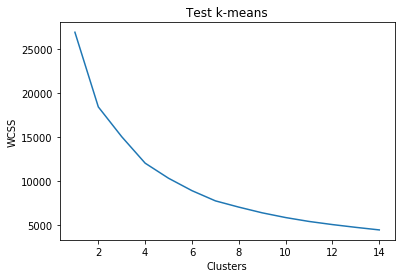

In [36]:
Fin2=Fin.loc[Fin['Reqs']<5000,:]
X=Fin2.loc[:,['Reqs','TS Per','Mean Session']].values
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')


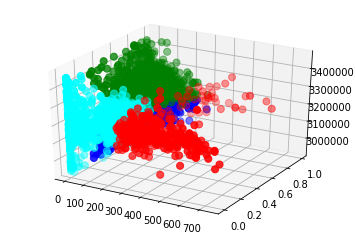

In [37]:
kmeans = KMeans(n_clusters =4, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
Y=Fin2.loc[:,['Reqs','TS Per','Mean Session']].values
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[y_kmeans ==0,0],Y[y_kmeans ==0,1],Y[y_kmeans ==0,2],s=50,c='red',label ='1')
ax.scatter(Y[y_kmeans ==1,0],Y[y_kmeans ==1,1],Y[y_kmeans ==1,2],s=50,c='blue',label ='2')
ax.scatter(Y[y_kmeans ==2,0],Y[y_kmeans ==2,1],Y[y_kmeans ==2,2],s=50,c='green',label ='3')
ax.scatter(Y[y_kmeans ==3,0],Y[y_kmeans ==3,1],Y[y_kmeans ==3,2],s=50,c='cyan',label ='4')
#ax.scatter(Y[y_kmeans ==4,0],Y[y_kmeans ==4,1],Y[y_kmeans ==4,2],s=50,c='yellow',label ='5')
#ax.title('Cluster')
#ax.xlabel('Number of Reqs')
#ax.ylabel('TS/Total Req')
#ax.zlabel('Mean Session Time')
#ax.legend()
#ax.show

In [38]:
Fin2['Cluster']=y_kmeans
Fin2.to_csv('Result2.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0,0.5,'WCSS')

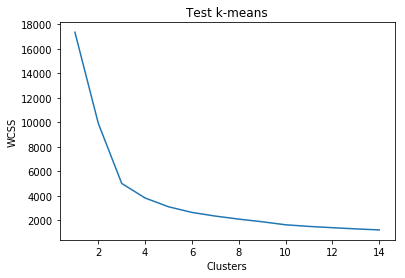

In [50]:
Fin3=Fin.loc[Fin['Reqs']<5000,:]
col=Fin3.apply(lambda row : 1/row['Reqs'], axis = 1)
Fin3['1/Reqs']=col
Fin3=Fin3.loc[Fin3['1/Reqs']<0.05,:]
X=Fin3.loc[:,['1/Reqs','TS Per']].values
from sklearn.preprocessing import StandardScaler
sc_X =StandardScaler()
X=sc_X.fit_transform(X)
from sklearn.cluster import KMeans
wcss =[]
for i in range (1,15):
    print(i)
    kmeans= KMeans(n_clusters = i, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Test k-means')
plt.xlabel('Clusters')
plt.ylabel('WCSS')

<function matplotlib.pyplot.show>

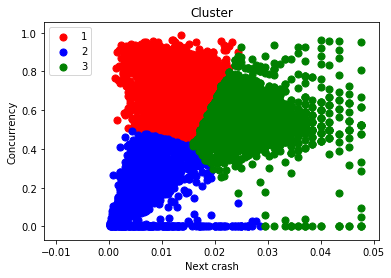

In [51]:
kmeans = KMeans(n_clusters =3, init = 'k-means++' , max_iter = 300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
Y=Fin3.loc[:,['1/Reqs','TS Per']].values


plt.scatter(Y[y_kmeans ==0,0],Y[y_kmeans ==0,1],s=50,c='red',label ='1')
plt.scatter(Y[y_kmeans ==1,0],Y[y_kmeans ==1,1],s=50,c='blue',label ='2')
plt.scatter(Y[y_kmeans ==2,0],Y[y_kmeans ==2,1],s=50,c='green',label ='3')
#plt.scatter(Y[y_kmeans ==3,0],Y[y_kmeans ==3,1],s=50,c='black',label ='4')
plt.title('Cluster')
plt.xlabel('Next crash')
plt.ylabel('Concurrency')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

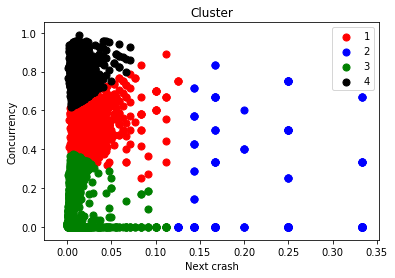

In [46]:

plt.scatter(Y[y_kmeans ==0,0],Y[y_kmeans ==0,1],s=50,c='red',label ='1')
plt.scatter(Y[y_kmeans ==1,0],Y[y_kmeans ==1,1],s=50,c='blue',label ='2')
plt.scatter(Y[y_kmeans ==2,0],Y[y_kmeans ==2,1],s=50,c='green',label ='3')
plt.scatter(Y[y_kmeans ==3,0],Y[y_kmeans ==3,1],s=50,c='black',label ='4')
plt.title('Cluster')
plt.xlabel('Next crash')
plt.ylabel('Concurrency')
plt.legend()
plt.show

In [52]:
Fin3['Cluster']=y_kmeans
Fin3.to_csv('Clust5.csv')

In [ ]:
## Linear classification test on this dataset

<class 'numpy.ndarray'>
[[ 280  147]
 [  48 1695]]
(6508, 2)
0 0.0
(6508,)
<class 'numpy.ndarray'>
(6508, 2)
1 1.0
(6508,)
<class 'numpy.ndarray'>


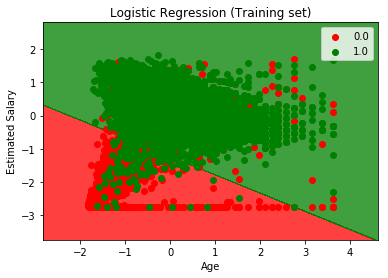

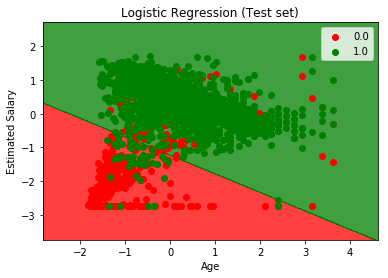

In [68]:
X = Fin3.loc[:,['1/Reqs','TS Per']].values
y = Fin3.loc[:, 'Timewriter'].values
print(type(X))
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    print(X_set.shape)
    print(i,j)
    print(y_set.shape)
    print(type(X_set))
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

<class 'numpy.ndarray'>
[[ 277  156]
 [  41 1679]]


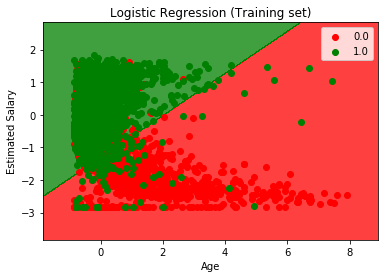

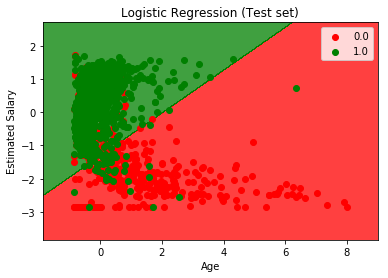

In [70]:
X = Fin2.loc[Fin2['Reqs']>20,['Reqs','TS Per']].values
y = Fin2.loc[Fin2['Reqs']>20, 'Timewriter'].values
print(type(X))
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

## Working on the influence of inputs on Elapsed time

In [4]:
from sklearn import preprocessing
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dt=Dataset.loc[Dataset['Elapsed']<5000,['Elapsed','Concurrency','EventID']]
Dt2=Dt.groupby(by=['EventID','Concurrency']).mean()
Dt3=Dt.groupby(by=['EventID','Concurrency']).count()
Dt3.columns=['Nbr occurencies']
Dt=Dt2.merge(Dt3,right_index=True,left_index=True)
Dt.to_csv('Dt.csv')
Dt=pandas.read_csv('Dt.csv')
Dt=Dt.loc[Dt['Nbr occurencies']>9,:]
Liste=Dt[['EventID']]
Liste=Liste.drop_duplicates()
Liste=Liste.loc[:,'EventID'].values
Tab=Dt.head(n=1)
for i in tqdm(Liste):
    Tab_int=Dt.loc[Dt['EventID']==i,:]
    x = Tab_int[['Elapsed']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    Tab_int['Elapsed'] = x_scaled
    Tab=pandas.concat([Tab,Tab_int])
Tab=Tab.groupby(by='Concurrency').mean()

FY=Tab.loc[11,:].values
FX=Tab.loc[4,:].values
Conc=np.zeros((50,2))
for i in range (1,50) :
    b=(FY-FX)*(i-4)/7+ FX
    Conc[i,0]=i
    Conc[i,1]=b
    
    

  0%|          | 0/267 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 267/267 [00:20<00:00, 12.96it/s]


TypeError: data type not understood

In [ ]:
## Comparisation table
This next file gives the rating of a concurrency

In [ ]:
FY=Tab.loc[11,:].values
FX=Tab.loc[4,:].values
Conc=np.zeros(50,2)
for i in range (1,50) :
    b=(FY-FX)*(i-4)/7+ FX
    Conc[i,0]=i
    Conc[i,1]=b
    
#Transform to a df?

(23416, 4)


  0%|          | 0/8527 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 8527/8527 [17:14<00:00,  8.24it/s]


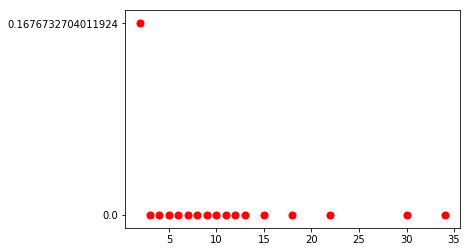

In [88]:
from sklearn import preprocessing
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dt=Dataset.loc[Dataset['Elapsed']<5000,['Elapsed','Concurrency','UserID']]
Dt2=Dt.groupby(by=['UserID','Concurrency']).mean()
Dt3=Dt.groupby(by=['UserID','Concurrency']).count()
Dt3.columns=['Nbr occurencies']
Dt=Dt2.merge(Dt3,right_index=True,left_index=True)
Dt.to_csv('Dt2.csv')
Dt=pandas.read_csv('Dt2.csv')
Dt=Dt.loc[Dt['Nbr occurencies']>9,:]
print(Dt.shape)
Liste=Dt[['UserID']]
Liste=Liste.drop_duplicates()
Liste=Liste.loc[:,'UserID'].values
Tab=Dt.head(n=1)
for i in tqdm(Liste):
    Tab_int=Dt.loc[Dt['UserID']==i,:]
    x = Tab_int[['UserID']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    Tab_int['Elapsed'] = x_scaled
    Tab=pandas.concat([Tab,Tab_int])
Tab=Tab.groupby(by='Concurrency').mean()

#plot
plt.scatter(Tab.index,Tab[['Elapsed']],s=50,c='red',label ='1')
plt.show()

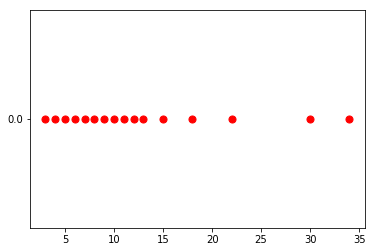

In [87]:
Tab2=Tab.loc[Tab['Elapsed']<0.15,:]
plt.scatter(Tab2.index,Tab2[['Elapsed']],s=50,c='red',label ='1')
plt.show()

## Attempt at calculating the mean elapsed per day to see the global trend (then per hour)

In [35]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<5000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

DT=Dataset[['UserID','Concurrency','EventID','Elapsed','StartTime']]
DT=DT.merge(RS2,left_on='EventID',right_index=True)
DT=DT.merge(Res2,left_on='UserID',right_index=True)
DT=DT.merge(Conc,left_on='Concurrency',right_on='Concurrency')

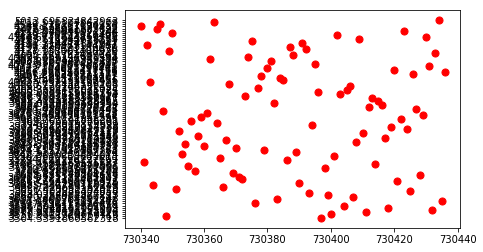

In [42]:

#DT['StartTime']=DT['StartTime'].apply(transfo_date)
DT['Jour']=DT['StartTime'].apply(perday)

col=DT.apply(lambda row :row['Elapsed']/(row['Event Grade']*row['User Grade']*row['Grade']),axis=1)
DT['Norm elapsed']=col
DTplt=DT[['Norm elapsed','Jour']]
DTplt=DTplt.groupby(by='Jour').mean()
plt.scatter(DTplt.index,DTplt[['Norm elapsed']],s=50,c='red',label ='1')
plt.show()

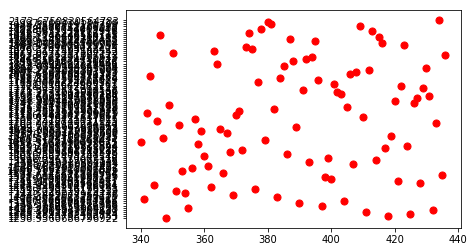

In [47]:
D=Dataset[['Elapsed','StartTime','EventID']]
D=D.loc[D['EventID'].notnull(),:]
D['StartTime']=D['StartTime'].apply(transfo_date)
D['Jour']=D['StartTime'].apply(perday)
D=D.groupby(by='Jour').mean()
plt.scatter(D.index,D[['Elapsed']],s=50,c='red',label ='1')
plt.show()

In [ ]:
## Same Analysis but only on my project

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

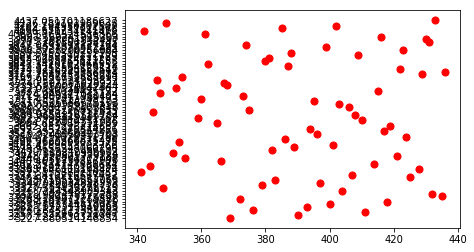

In [56]:
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

DT=Dataset[['UserID','Concurrency','EventID','Elapsed','StartTime']]
DT=DT.merge(RS2,left_on='EventID',right_index=True)
DT=DT.merge(Res2,left_on='UserID',right_index=True)
DT=DT.merge(Conc,left_on='Concurrency',right_on='Concurrency')


D=DT.loc[DT['EventID']=='uBBaQgfD',:]

col=D.apply(lambda row :row['Elapsed']/(row['Event Grade']*row['User Grade']*row['Grade']),axis=1)
D['Norm elapsed']=col

D['StartTime']=D['StartTime'].apply(transfo_date)
D['Jour']=D['StartTime'].apply(perday)
D1=D.groupby(by='Jour').mean()
D2=D[['Jour','Elapsed']]
D2=D2.groupby(by='Jour').count()
D2.columns=['NBR']
D3=D1.merge(D2,right_index=True,left_index=True)
D3=D3.loc[D3['NBR']>100,:]
plt.scatter(D3.index,D3[['Norm elapsed']],s=50,c='red',label ='1')
plt.show()

## Analysis on recalculated elapsed time per hour

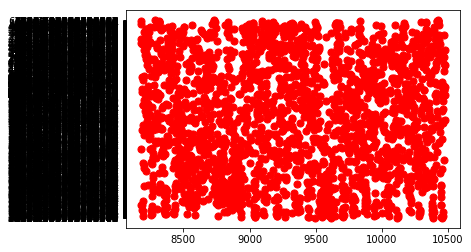

In [62]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<5000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

DT=Dataset[['UserID','Concurrency','EventID','Elapsed','StartTime']]
DT=DT.merge(RS2,left_on='EventID',right_index=True)
DT=DT.merge(Res2,left_on='UserID',right_index=True)
DT=DT.merge(Conc,left_on='Concurrency',right_on='Concurrency')
DT['StartTime']=DT['StartTime'].apply(transfo_date)
DT['Jour']=DT['StartTime'].apply(perhour)

col=DT.apply(lambda row :row['Elapsed']/(row['Event Grade']*row['User Grade']*row['Grade']),axis=1)
DT['Norm elapsed']=col
DTplt=DT[['Norm elapsed','Jour']]
DTplt=DTplt.groupby(by='Jour').mean()
plt.scatter(DTplt.index,DTplt[['Norm elapsed']],s=50,c='red',label ='1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

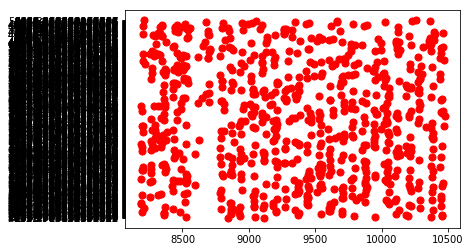

In [59]:
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

DT=Dataset[['UserID','Concurrency','EventID','Elapsed','StartTime']]
DT=DT.merge(RS2,left_on='EventID',right_index=True)
DT=DT.merge(Res2,left_on='UserID',right_index=True)
DT=DT.merge(Conc,left_on='Concurrency',right_on='Concurrency')


D=DT.loc[DT['EventID']=='uBBaQgfD',:]

col=D.apply(lambda row :row['Elapsed']/(row['Event Grade']*row['User Grade']*row['Grade']),axis=1)
D['Norm elapsed']=col

D['StartTime']=D['StartTime'].apply(transfo_date)
D['Jour']=D['StartTime'].apply(perhour)
D1=D.groupby(by='Jour').mean()
D2=D[['Jour','Elapsed']]
D2=D2.groupby(by='Jour').count()
D2.columns=['NBR']
D3=D1.merge(D2,right_index=True,left_index=True)
D3=D3.loc[D3['NBR']>10,:]
plt.scatter(D3.index,D3[['Norm elapsed']],s=50,c='red',label ='1')
plt.show()

## Quick Analysis on the number of requests in January and December

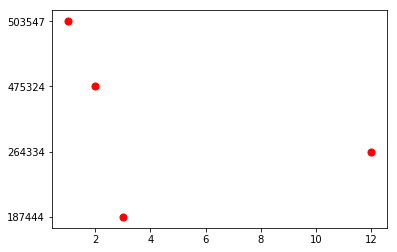

,Concurrency
month,
1,3.551363
2,3.323560
3,3.653625
12,2.992177


In [111]:
# Number of requests per month then the ones from january
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['month']=dataset['StartTime'].apply(month)
dt=dataset[['month','EntryID']]
dt=dt.groupby(by='month').count()
plt.scatter(dt.index,dt[['EntryID']],s=50,c='red',label ='1')
plt.show()

dt2=dataset[['Concurrency','month']]
dt2=dt2.groupby(by='month').mean()
dt2

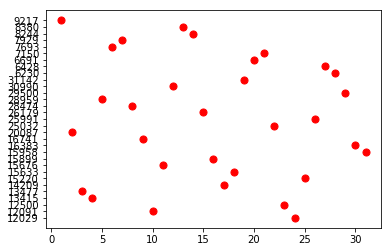

,Concurrency
day,
1,2.752306
2,3.229651
3,3.039549
4,3.009169
5,3.785421
6,2.599766
7,2.626056
8,4.087729
9,3.238994


In [113]:
# Number of requests per month then the ones from january
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['month']=dataset['StartTime'].apply(month)
dataset=dataset.loc[dataset['month']==1,:]
dataset['day']=dataset['StartTime'].apply(day)
dt=dataset[['day','EntryID']]
dt=dt.groupby(by='day').count()
plt.scatter(dt.index,dt[['EntryID']],s=50,c='red',label ='1')
plt.show()
dt.to_csv('Repart.csv')
dt2=dataset[['Concurrency','day']]
dt2=dt2.groupby(by='day').mean()
dt2

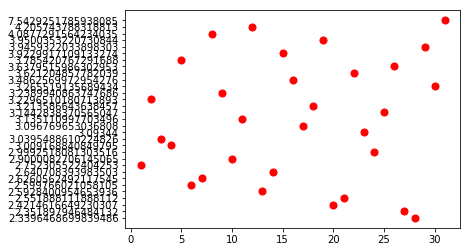

In [114]:
plt.scatter(dt2.index,dt2[['Concurrency']],s=50,c='red',label ='1')
plt.show()

In [ ]:
For Timewriters

In [116]:
TM=pandas.read_csv('internal-id.txt')
X=TM.loc[:,:].values
a=X.shape[0]
l=[1]*a
TM['Timewriter']=l
Tab=dataset.merge(TM, left_on='UserID',right_on='InternalID',how='left')
Tab['Timewriter']=Tab['Timewriter'].fillna(0)

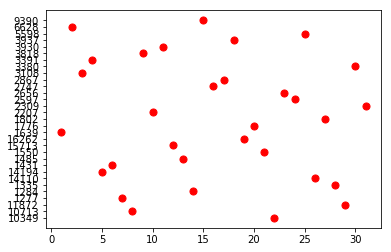

,Concurrency
day,
1,2.752306
2,3.229651
3,3.039549
4,3.009169
5,3.785421
6,2.599766
7,2.626056
8,4.087729
9,3.238994


In [117]:
dt=Tab.loc[Tab['Timewriter']==1,['day','EntryID']]
dt=dt.groupby(by='day').count()
plt.scatter(dt.index,dt[['EntryID']],s=50,c='red',label ='1')
plt.show()
dt.to_csv('Repart.csv')
dt2=dataset[['Concurrency','day']]
dt2=dt2.groupby(by='day').mean()
dt2

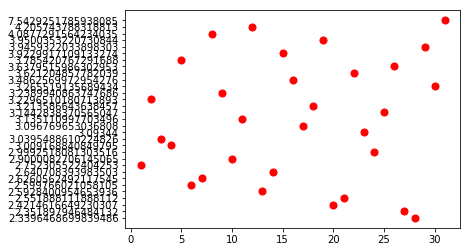

In [118]:
plt.scatter(dt2.index,dt2[['Concurrency']],s=50,c='red',label ='1')
plt.show()

(332, 1)


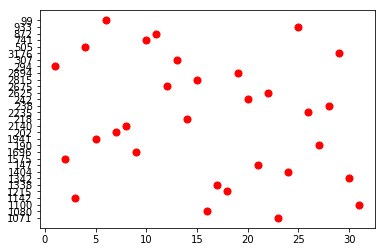

,Concurrency
day,
1,2.752306
2,3.229651
3,3.039549
4,3.009169
5,3.785421
6,2.599766
7,2.626056
8,4.087729
9,3.238994


In [133]:
# For the users of myproject
Liste=dataset.loc[dataset['EventID']=='uBBaQgfD',:]
Liste.shape[0]
Liste2=dataset.loc[dataset['WorkspaceID']=='uBBaQgfD',:]
Liste2.shape[0]
Liste=pandas.concat([Liste,Liste2])
Liste=Liste.drop_duplicates()
LL=Liste[['UserID','EntryID']]
LL=LL.groupby(by='UserID').count()
LL.columns=['Count']
Liste=Liste.merge(LL,left_on='UserID',right_index=True)
Liste=Liste.loc[Liste['Count']>50,:]
Liste=Liste[['UserID']]

Liste=Liste.drop_duplicates()
print(Liste.shape)
dt=dataset.merge(Liste,how='inner',on='UserID')
dt=dt[['EntryID','day']]
dt=dt.groupby(by='day').count()
plt.scatter(dt.index,dt[['EntryID']],s=50,c='red',label ='1')
plt.show()
dt.to_csv('Repart2.csv')
dt2=dataset[['Concurrency','day']]
dt2=dt2.groupby(by='day').mean()
dt2

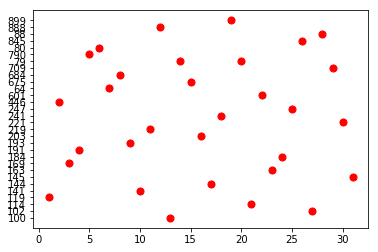

,Concurrency
day,
1,2.752306
2,3.229651
3,3.039549
4,3.009169
5,3.785421
6,2.599766
7,2.626056
8,4.087729
9,3.238994


In [137]:
#For MyProject requests
dt=dataset.loc[dataset['EventID']=='uBBaQgfD',:]

dt=dt.drop_duplicates()
dt=dt[['EntryID','day']]
dt=dt.groupby(by='day').count()
plt.scatter(dt.index,dt[['EntryID']],s=50,c='red',label ='1')
plt.show()
dt.to_csv('Repart2.csv')
dt2=dataset[['Concurrency','day']]
dt2=dt2.groupby(by='day').mean()
dt2

## Analysis on the On/off users

In [140]:
#Determining the % of count(requests)
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['month']=dataset['StartTime'].apply(month)
dataset=dataset.loc[dataset['Elapsed']<5000,:]
dataset1=dataset.loc[dataset['month']==1,:]
dataset1=dataset1[['EntryID','EventID']]
dataset1=dataset1.groupby(by='EventID').count()
dataset2=dataset.loc[dataset['month']==12,:]
dataset2=dataset2[['EntryID','EventID']]
dataset2=dataset2.groupby(by='EventID').count()
DT=dataset1.merge(dataset2, right_index=True,left_index=True)
DT.to_csv('DT.csv')

In [4]:
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset=dataset[['StartTime','UserID']]
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['Hr']=dataset['StartTime'].apply(perhour)
dataset=dataset.groupby(by=['UserID','Hr']).count()
dataset.to_csv('HR.csv')
dataset=pandas.read_csv('HR.csv')

In [11]:
A=dataset[['UserID']].drop_duplicates()
A=A.sample(n=10).values[:,0]
print(A)

for i in A :
    B=dataset.loc[dataset['UserID']==i,['Hr','StartTime']]
    plt.scatter(B['Hr'],B['StartTime'],s=50,c='red',label ='Nbr requests')
    plt.title('User usage')
    plt.xlabel('Date')
    plt.ylabel('Nbr requests')
    plt.legend()
    plt.show
    plt.savefig('testplot_user_'+str(i)+'.png')
    plt.clf()

[   63100  8558326    59545  8560112    63517 10134723  1905508  8946562
  9610025    61616]


In [17]:
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset=dataset[['StartTime','UserID']]
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['Hr']=dataset['StartTime'].apply(troncat_hour_week)
dataset['Wk']=dataset['StartTime'].apply(nbr_week)
Wk=dataset[['Wk']].drop_duplicates()
print(Wk)
Days=dataset[['Wk','Hr']].drop_duplicates()
dataset=dataset.groupby(by=['UserID','Hr','Wk']).count()
dataset.to_csv('HR.csv')
dataset=pandas.read_csv('HR.csv')

         Wk
0        49
32958    50
128526   51
214000   52
264334    1
365111    2
485707    3
602610    4
706040    5
834578    6
960821    7
1073857   8
1188408   9
1297978  10
1398344  11


In [30]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
a=Wk.shape[0]

import matplotlib
import random
l=[]
for name in matplotlib.colors.cnames.items():
    l.append(name)
random.shuffle(l)
lbis=l[:a]
lter=[]
for i in range (a):
    lter.append(lbis[i][0])
print(lter)
Wk['color']=lter

         Wk                                              color
0        49  <matplotlib.colors.LinearSegmentedColormap obj...
32958    50  <matplotlib.colors.LinearSegmentedColormap obj...
128526   51  <matplotlib.colors.LinearSegmentedColormap obj...
214000   52  <matplotlib.colors.LinearSegmentedColormap obj...
264334    1  <matplotlib.colors.LinearSegmentedColormap obj...
365111    2  <matplotlib.colors.LinearSegmentedColormap obj...
485707    3  <matplotlib.colors.LinearSegmentedColormap obj...
602610    4  <matplotlib.colors.LinearSegmentedColormap obj...
706040    5  <matplotlib.colors.LinearSegmentedColormap obj...
834578    6  <matplotlib.colors.LinearSegmentedColormap obj...
960821    7  <matplotlib.colors.LinearSegmentedColormap obj...
1073857   8  <matplotlib.colors.LinearSegmentedColormap obj...
1188408   9  <matplotlib.colors.LinearSegmentedColormap obj...
1297978  10  <matplotlib.colors.LinearSegmentedColormap obj...
1398344  11  <matplotlib.colors.LinearSegmentedColormap

In [32]:
Res=Days.merge(dataset,on=['Hr','Wk'],how='outer')
Res1=Res.groupby(by=['Hr','Wk']).count()
Res1.to_csv('Res1.csv')
Res1=pandas.read_csv('Res1.csv')
#plot avec les couleurs pour le global
j=0
for i in Wk.loc[:,'Wk'].values:
    plt.scatter(Res1.loc[Res1['Wk']==i,'Hr'],Res1.loc[Res1['Wk']==i,'StartTime'],s=50,c=Wk.loc[Wk['Wk']==i,'color'],label ='Week_'+str(i))
    j+=1
plt.title('User usage')
plt.xlabel('Date')
plt.ylabel('Nbr user')
plt.legend()
plt.show
plt.savefig('testplot_wk.png')
plt.clf()

In [35]:
### User per user

dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset=dataset[['StartTime','UserID']]
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['Hr']=dataset['StartTime'].apply(perhour)
Dt=dataset[['Hr','UserID','StartTime']].drop_duplicates(subset=['Hr','UserID'])
Dt=Dt.groupby(by=['Hr','UserID']).count()
Dt.to_csv('Dt.csv')
Dt=pandas.read_csv('Dt.csv')
Date=dataset[['Hr',]].drop_duplicates()
Res2=Date.merge(Dt,how='outer',right_index=True,left_on='Hr')
Res2=Res2.fillna(0)

In [36]:
A=dataset[['UserID']].drop_duplicates()
A=A.sample(n=10).values[:,0]
print(A)

for i in A :
    B=Res2.loc[Res2['UserID']==i,['Hr','StartTime']]
    plt.scatter(B['Hr'],B['StartTime'],s=50,c='red',label ='Nbr requests')
    plt.title('User usage')
    plt.xlabel('Date')
    plt.ylabel('Nbr requests')
    plt.legend()
    plt.show
    plt.savefig('testplot_user_'+str(i)+'.png')
    plt.clf()

[   59299    57921 20465652 12838713    60380    58845    58592 14683405
  3179448    61775]


In [38]:
dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset=dataset[['StartTime','UserID']]
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['Hr']=dataset['StartTime'].apply(troncat_hour_week)
dataset['Wk']=dataset['StartTime'].apply(nbr_week)


Wk=dataset[['Wk']].drop_duplicates()
print(Wk)


Dt=dataset[['Wk','Hr','UserID','StartTime']].drop_duplicates(subset=['Wk','Hr','UserID'])
Dt=Dt.groupby(by=['Wk','Hr','UserID']).count()
Dt.to_csv('Dt.csv')
Dt=pandas.read_csv('Dt.csv')

a=Wk.shape[0]

import matplotlib
import random
l=[]
for name in matplotlib.colors.cnames.items():
    l.append(name)
random.shuffle(l)
lbis=l[:a]
lter=[]
for i in range (a):
    lter.append(lbis[i][0])
print(lter)
Wk['color']=lter

A=dataset[['UserID']].drop_duplicates()
A=A.sample(n=10).values[:,0]
print(A)

for j in A :
    Res2=Dt.loc[Dt['UserID']==j,['Wk','Hr','StartTime']]
    for i in Wk.loc[:,'Wk'].values:
        plt.scatter(Res2.loc[Res2['Wk']==i,'Hr'],Res2.loc[Res2['Wk']==i,'StartTime'],s=50,c=Wk.loc[Wk['Wk']==i,'color'],label ='Week_'+str(i))
    plt.title('User usage')
    plt.xlabel('Date')
    plt.ylabel('Nbr requests')
    plt.legend()
    plt.show
    plt.savefig('testplot_user_'+str(j)+'.png')
    plt.clf()



         Wk
0        49
32958    50
128526   51
214000   52
264334    1
365111    2
485707    3
602610    4
706040    5
834578    6
960821    7
1073857   8
1188408   9
1297978  10
1398344  11
['lightpink', 'limegreen', 'mediumorchid', 'darkorange', 'darkslateblue', 'mediumseagreen', 'lavender', 'cornflowerblue', 'darkseagreen', 'maroon', 'beige', 'darkcyan', 'lightblue', 'skyblue', 'papayawhip']
[   60059  9459842  9611800  8515871  3179539    61284 19616712 27667219
  8557611 28426728]


## On off prediction

In [43]:
#faire une liste de 25 a 25*8 pour les Wk, ajouter une colonne vide, idem avec la semaine
#faire une liste de user, ajouter une colonne vide
#merge sur la colonne vide -> 

dataset=pandas.read_csv('Concrrencies_allservers.csv')
dataset=dataset[['StartTime','UserID']]
dataset['StartTime']=dataset['StartTime'].apply(transfo_date)
dataset['Hr']=dataset['StartTime'].apply(troncat_hour_week)
dataset['Wk']=dataset['StartTime'].apply(nbr_week)
Dt=dataset[['Wk','Hr','UserID','StartTime']].drop_duplicates(subset=['Wk','Hr','UserID'])
Dt=Dt.groupby(by=['Wk','Hr','UserID']).count()
Dt.to_csv('Dt.csv')
Dt=pandas.read_csv('Dt.csv')

User=Dt[['UserID']].drop_duplicates()
Wk=Dt[['Wk']].drop_duplicates()
Hr=Dt[['Hr']].drop_duplicates()
la=np.zeros(User.shape[0])
lb=np.zeros(Wk.shape[0])
lc=np.zeros(Hr.shape[0])
User['StartTime']=la
Wk['StartTime']=lb
Hr['StartTime']=lc
AA=User.merge(Wk, how='outer', on='StartTime')
AA=AA.merge(Hr, how='outer', on='StartTime')


In [46]:
Res=pandas.concat([Dt,AA])
Res=Res.sort_values(by='StartTime',ascending=False)
Res=Res.drop_duplicates(subset=['UserID','Hr','Wk'],keep='first')


In [53]:
Res2=Res[['UserID','Hr','StartTime']].groupby(by=['UserID','Hr']).mean()
Res2.to_csv('Res2.csv')
Res2=pandas.read_csv('Res2.csv')

In [54]:
print(Res2)

            UserID   Hr  StartTime
0                2   25        0.0
1                2   26        0.0
2                2   27        0.0
3                2   28        0.0
4                2   29        0.0
5                2   30        0.0
6                2   31        0.0
7                2   32        0.0
8                2   33        0.0
9                2   34        0.0
10               2   35        0.0
11               2   36        0.0
12               2   37        0.0
13               2   38        0.0
14               2   39        0.0
15               2   40        0.0
16               2   41        0.0
17               2   42        0.0
18               2   43        0.0
19               2   44        0.0
20               2   45        0.0
21               2   46        0.0
22               2   47        0.0
23               2   48        0.0
24               2   50        0.0
25               2   51        0.0
26               2   52        0.0
27               2  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


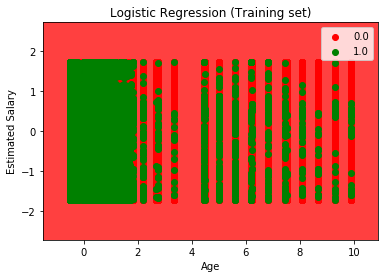

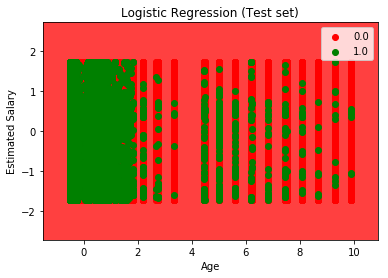

In [56]:
X=Res.loc[:,['UserID','Hr']].values
y=Res.loc[:,'StartTime'].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

In [50]:
print(cm)

[[5665155       0]
 [  45165       0]]


In [ ]:
X=Res2.loc[:,['UserID','Hr']].values
y=Res2.loc[:,'StartTime'].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

In [ ]:
X=Res2.loc[:,['UserID','Hr']].values
y=Res2.loc[:,'StartTime'].values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

onehotencoder=OneHotEncoder(categorical_features =[0])
X=onehotencoder.fit_transform(X).toarray()

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)



In [58]:
X=Res2.loc[:,['UserID','Hr']].values
y=Res2.loc[:,'StartTime'].values

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

import statsmodels.formula.api as sm
X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0, 1, 2]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     992.1
Date:                Fri, 25 May 2018   Prob (F-statistic):               0.00
Time:                        13:15:26   Log-Likelihood:             2.7526e+06
No. Observations:             1522752   AIC:                        -5.505e+06
Df Residuals:                 1522749   BIC:                        -5.505e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111   7.97e-05    139.618      0.000       0.011       0.011
x1         -4.041e-11    2.4e-12    -16.805      0.000   -4.51e-11   -3.57e-11
x2         -2.629e-05   6.37e-07    -41.252      0.000   -2.75e-05    -2.5e-05
==============================================================================
Omnibus:                  2380521.087   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1526823681.897
Skew:                          10.055   Prob(JB):                         0.00
Kurtosis:                     156.817   Cond. No.                     3.71e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#Tresshold concurrency vs elapsed
#

## Attempt at creating at plotting the Event rating and User rating

In [4]:
from sklearn import preprocessing
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dt=Dataset.loc[Dataset['Elapsed']<5000,['Elapsed','Concurrency','EventID']]
Dt2=Dt.groupby(by=['EventID','Concurrency']).mean()
Dt3=Dt.groupby(by=['EventID','Concurrency']).count()
Dt3.columns=['Nbr occurencies']
Dt=Dt2.merge(Dt3,right_index=True,left_index=True)
Dt.to_csv('Dt.csv')
Dt=pandas.read_csv('Dt.csv')
Dt=Dt.loc[Dt['Nbr occurencies']>9,:]
Liste=Dt[['EventID']]
Liste=Liste.drop_duplicates()
Liste=Liste.loc[:,'EventID'].values
Tab=Dt.head(n=1)
for i in tqdm(Liste):
    Tab_int=Dt.loc[Dt['EventID']==i,:]
    x = Tab_int[['Elapsed']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    Tab_int['Elapsed'] = x_scaled
    Tab=pandas.concat([Tab,Tab_int])
Tab=Tab.groupby(by='Concurrency').mean()

D=Dataset[['Concurrency']]
print(D.max().values[0])

FY=Tab.loc[11,'Elapsed']
FX=Tab.loc[4,'Elapsed']
Conc=np.zeros((int(D.max().values[0]),2))
for i in range (1,int(D.max().values[0])) :
    b=(FY-FX)*(i-4)/7+ FX
    Conc[i][0]=i
    Conc[i][1]=b
Conc=pandas.DataFrame(Conc, columns=['Concurrency','Grade'])
    

  0%|          | 0/267 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 267/267 [00:22<00:00, 11.72it/s]


167.0


In [6]:

FY=Tab.loc[11,'Elapsed']
FX=Tab.loc[4,'Elapsed']
Conc=np.zeros((167,2))
for i in range (1,167) :
    b=(FY-FX)*(i-4)/7+ FX
    Conc[i][0]=i
    Conc[i][1]=b
Conc=pandas.DataFrame(Conc, columns=['Concurrency','Grade'])

In [101]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
D=Dataset[['Concurrency']]
D.max()

Concurrency    167.0
dtype: float64

In [25]:
#Ajouter une regression lineaire sur les Events avec la methode d'avant? ou la laisser sur une triple regression lineaire

##TO DO : Crete a Event Rate, then take the normalized mean for every user (request/meanrequest then groub by), then add the concurrency rate and plot the whole thing
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
User_requests=Dataset[['EventID','Elapsed']]
User_requests=User_requests.loc[User_requests['Elapsed']<5000,:]
User_requests2=User_requests.groupby(by=['EventID']).var()
User_requests=User_requests.groupby(by=['EventID']).mean()
User_requests.columns=['Event Grade']
User_requests2.columns=['Event Grade']
###Change here and create a EventID Rating
Req=Dataset[['UserID','Elapsed']]
Req=Req.loc[Req['Elapsed']<5000,:]
Req2=Req.groupby(by='UserID').var()
Req2.columns=['User Grade']
Req=Req.groupby(by='UserID').mean()
Req.columns=['User Grade']
##Same but instead of the mean, we have the rating
Rate=Dataset[['EventID','Elapsed','UserID','Concurrency']]
Rate=Rate.loc[Rate['Elapsed']<5000,:]
Rate=Rate.merge(User_requests,left_on='EventID',right_index=True)
Rate=Rate.merge(Conc,left_on='Concurrency',right_on='Concurrency')
Rate=Rate.merge(Req,left_on='UserID',right_index=True)

Rate2=Dataset[['EventID','Elapsed','UserID','Concurrency']]
Rate2=Rate2.merge(User_requests2,left_on='EventID',right_index=True)
Rate2=Rate2.merge(Req2,left_on='UserID',right_index=True)

print(Req2,User_requests2)
### Merge Dataset original with Rating, User Rating, Concurrencies and plot the whole thing

             User Grade
UserID                 
2                   NaN
20844      1.206714e+06
20846      1.558824e+06
20849      9.089966e+05
20851      1.497894e+06
20852      8.850286e+05
20854      4.639943e+05
29953      1.176720e+06
56536      9.771731e+05
56537      9.107226e+05
56538      1.376410e+06
56540      9.564857e+05
56543      6.894181e+05
56544      9.233032e+05
56545      1.055076e+06
56546      1.423980e+06
56547      1.122428e+06
56551      7.157246e+05
56552      6.360709e+05
56553      9.521185e+05
56554      1.186322e+06
56555      7.219828e+05
56557      1.578151e+06
56558      6.094108e+05
56559      5.810207e+05
56565      2.231688e+05
56566      9.695346e+05
56568      5.024172e+05
56569      3.175729e+05
56571      5.463114e+05
...                 ...
114614119  4.223876e+05
114617054  4.509907e+05
114622920  4.928504e+05
114627265  3.288758e+05
114627310           NaN
114634657  1.059926e+05
114640165  4.642518e+05
122854815  2.093509e+05
122860192  3.472

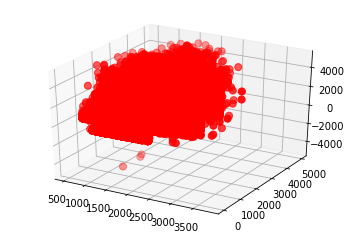

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Rate[['User Grade']],Rate[['Event Grade']],Rate[['Elapsed']],s=50,c='red',label ='1')


In [17]:
# Regression lineaire

X = Rate.loc[:, ['Grade','User Grade','Event Grade']].values
y = Rate.loc[:, 'Elapsed'].values


# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
"""from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)"""



ValueError: Expected 2D array, got 1D array instead:
array=[1406. 2012. 5443. ... 4811. 1417. 1770.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [18]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)



In [19]:
print(y_pred)

[ 2466.38825587 -1874.0166154   2676.839725   ...  3123.90158921
  1702.09016278  2220.40451869]


In [20]:
# Building the optimal model using Backward Elimination

import statsmodels.formula.api as sm
X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0, 1, 2, 3]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                 3.476e+04
Date:                Fri, 11 May 2018   Prob (F-statistic):               0.00
Time:                        12:44:28   Log-Likelihood:            -4.8457e+06
No. Observations:              442735   AIC:                         9.691e+06
Df Residuals:                  442731   BIC:                         9.692e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.566e+04     66.580   -235.235      0.000   -1.58e+04   -1.55e+04
x1          3.605e+04    117.924    305.680      0.000    3.58e+04    3.63e+04
x2             0.0364      0.005      7.991      0.000       0.027       0.045
x3             1.2641      0.027     46.349      0.000       1.211       1.318
===============================================================================
Omnibus:                  2537295.973   Durbin-Watson:                    1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   589052271410583.250
Skew:                         355.012   Prob(JB):                          0.00
Kurtosis:                  178695.853   Cond. No.                      3.47e+04
===============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Machine learning on rates adaptated

In [63]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<5000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

DT=Dataset[['StartTime','SessionID','EntryID','UserID','Concurrency','EventID','Elapsed']]
DT=DT.merge(RS2,left_on='EventID',right_index=True)
DT=DT.merge(Res2,left_on='UserID',right_index=True)
DT=DT.merge(Conc,left_on='Concurrency',right_on='Concurrency')

In [64]:
X = DT.loc[:, ['Grade','User Grade','Event Grade']].values
y = DT.loc[:, 'Elapsed'].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

import statsmodels.formula.api as sm
X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0, 1, 2, 3]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.347e+05
Date:                Fri, 01 Jun 2018   Prob (F-statistic):               0.00
Time:                        11:01:51   Log-Likelihood:            -3.3239e+06
No. Observations:              414091   AIC:                         6.648e+06
Df Residuals:                  414087   BIC:                         6.648e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1284.7729      6.534   -196.615      0.000   -1297.580   -1271.966
x1          1206.5732     10.647    113.323      0.000    1185.705    1227.441
x2           875.4545      3.950    221.641      0.000     867.713     883.196
x3          1484.3345      2.603    570.203      0.000    1479.232    1489.437
==============================================================================
Omnibus:                    93024.013   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           228243.382
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       5.650   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
regressor.score(X[:,1:],y)

0.49386552531316014

In [43]:
regressor_OLS.params

array([-1284.77287844,  1206.57317347,   875.45454518,  1484.33447101])

In [65]:
z=X*regressor_OLS.params
z=np.sum(z, axis=1)
print(z.shape)
DT['predict']=z

(414091,)


In [72]:
DT.loc[DT['predict']<0,:]

,StartTime,SessionID,EntryID,UserID,Concurrency,EventID,Elapsed,Event Grade,User Grade,Grade,predict
14959,2017-12-08 14:42:21.519,2939128,245,8796245,2.0,BkTdY1rWW9,40,0.017040,0.909886,0.355652,-33.796371
14960,2017-12-11 08:53:13.233,2950336,306,8796245,2.0,BkTdY1rWW9,54,0.017040,0.909886,0.355652,-33.796371
14961,2017-12-11 11:48:01.616,2950913,418,8796245,2.0,BkTdY1rWW9,58,0.017040,0.909886,0.355652,-33.796371
14962,2017-12-11 11:48:13.630,2950913,420,8796245,2.0,BkTdY1rWW9,19,0.017040,0.909886,0.355652,-33.796371
15089,2017-12-18 13:21:03.477,2983244,80,63352,2.0,BkTdY1rVik,48,0.055446,0.787137,0.355652,-84.250925
15090,2017-12-18 13:21:56.148,2983244,87,63352,2.0,BkTdY1rVik,91,0.055446,0.787137,0.355652,-84.250925
15091,2017-12-18 13:32:19.021,2983244,128,63352,2.0,BkTdY1rVik,37,0.055446,0.787137,0.355652,-84.250925
15092,2017-12-18 13:32:28.260,2983244,131,63352,2.0,BkTdY1rVik,36,0.055446,0.787137,0.355652,-84.250925
15093,2017-12-18 13:32:31.532,2983244,132,63352,2.0,BkTdY1rVik,35,0.055446,0.787137,0.355652,-84.250925
15094,2018-01-12 07:39:35.247,3106535,203,63352,2.0,BkTdY1rVik,55,0.055446,0.787137,0.355652,-84.250925


In [66]:
DT.to_csv('Test.csv')

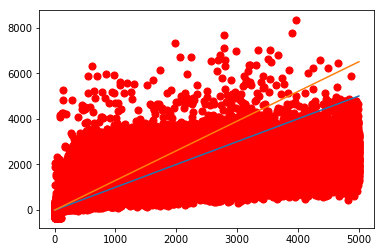

In [55]:
plt.scatter(DT.loc[DT['Elapsed']>0,'Elapsed'],DT.loc[DT['Elapsed']>0,'predict'],s=50,c='red',label ='1')
plt.plot([0,5000],[0,5000])
plt.plot([0,5000],[0,6500])
plt.show()

In [67]:
DT2=DT.loc[DT['Elapsed']>0,:]
col=DT2.apply(lambda row : row['predict']/row['Elapsed'],axis=1)
DT2['Rapport']=col
DT2['StartTime']=DT2['StartTime'].apply(transfo_date)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


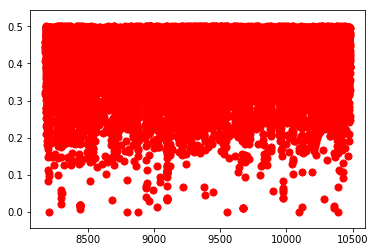

In [73]:
#print(DT2.loc[DT2['Rapport']>1,:].shape)
A=DT2.loc[DT2['Rapport']<0.5,:]
A=A.loc[A['Rapport']>0,:]
A['ST']=A['StartTime'].apply(perhour)
plt.scatter(A['ST'],A['Rapport'],s=50,c='red',label ='1')
plt.show()
#print(DT2.shape)

In [90]:
C=A[['ST','Rapport']].groupby(by='ST').count().merge(A[['ST','Rapport']].groupby(by='ST').mean(),left_index=True,right_index=True)


In [100]:

#DT2['ST']=DT2['StartTime'].apply(perhour)
C=DT2.loc[DT2['Rapport']>0,:]
C=C[['ST','Rapport']].groupby(by='ST').count().merge(C[['ST','Rapport']].groupby(by='ST').mean(),left_index=True,right_index=True)
print(C.sort_values(by='Rapport_y',ascending=True))

       Rapport_x  Rapport_y
ST                         
10426         58   0.547692
10425         62   0.586583
10420         48   0.596931
10424         53   0.604531
10422         98   0.634428
10421         47   0.656951
10419         44   0.678676
8730         124   0.763633
8178          11   0.769265
9495         175   0.853590
8731          87   0.895195
9831         130   0.907885
8312         210   0.918410
8732          79   0.920016
8317         296   0.924303
9176         221   0.926912
9675         100   0.939523
8740          78   0.959849
9506          95   0.962167
10167        187   0.965314
8315         262   0.968156
8838         112   0.968287
9139         164   0.970630
9318         258   0.970680
10176         71   0.971915
8313         222   0.973965
8282         116   0.989121
8812          77   0.998021
8180         240   0.999165
8985         121   1.001851
...          ...        ...
10053        585   1.593117
10221        645   1.594158
10454        532   1

In [105]:
D=A[['ST','Rapport']].groupby(by='ST').count().merge(A[['ST','Rapport']].groupby(by='ST').mean(),left_index=True,right_index=True)
D.columns=['Rapport x neg','Rapoort y neg']
#print(D.sort_values(by='Rapport_x',ascending=False))
F=C.merge(D, how='outer',left_index=True,right_index=True)
print(F.sort_values(by='Rapport x neg',ascending=False))

       Rapport_x  Rapport_y  Rapport x neg  Rapoort y neg
ST                                                       
8318         481   1.047245          111.0       0.355003
9097         280   1.302098           98.0       0.256653
8317         296   0.924303           76.0       0.354598
8315         262   0.968156           65.0       0.397231
8730         124   0.763633           61.0       0.336486
8313         222   0.973965           56.0       0.365788
9375         580   1.286017           51.0       0.398760
8271         704   1.505325           49.0       0.381578
8312         210   0.918410           46.0       0.384230
8205         540   1.394419           41.0       0.351141
9032         617   1.269343           40.0       0.392066
8311         205   1.048308           37.0       0.341421
9381         720   1.527136           37.0       0.383058
8870         610   1.204144           36.0       0.418177
10113        493   1.194157           36.0       0.426022
10383        6

In [107]:
DT2.loc[DT2['ST']==8730,:]

,StartTime,SessionID,EntryID,UserID,Concurrency,EventID,Elapsed,Event Grade,User Grade,Grade,predict,Rapport,ST
822,2017-12-30 18:33:56.633,3031595,3,63714,2.0,uM6VbDSi,1527,1.105407,0.959079,0.355652,1624.770543,1.064028,8730
20704,2017-12-30 18:42:27.958,3031615,18,57277,2.0,BkTdY1qSc6,1279,0.473133,1.921791,0.355652,1529.076245,1.195525,8730
50332,2017-12-30 18:26:35.841,3031565,4,62337,2.0,BkTdY1qSc6,661,0.473133,0.583523,0.355652,357.483391,0.540822,8730
50340,2017-12-30 18:25:40.769,3031565,2,62337,2.0,uBBaQgfD,1421,1.064933,0.583523,0.355652,1235.911493,0.869748,8730
53461,2017-12-30 18:11:06.329,3031515,34,57269,2.0,BkTdY1qSc6,1097,0.473133,1.501193,0.355652,1160.861678,1.058215,8730
53525,2017-12-30 18:37:05.684,3031602,3,323550,2.0,BkTdY1qSc6,304,0.473133,0.865902,0.355652,604.692728,1.989121,8730
74679,2017-12-30 18:13:37.927,3031459,729,22945814,2.0,BkTdY1qSc6,480,0.473133,0.666207,0.355652,429.868836,0.895560,8730
74719,2017-12-30 18:12:36.439,3031459,727,22945814,2.0,uBBaQgfD,1244,1.064933,0.666207,0.355652,1308.296938,1.051686,8730
92326,2017-12-30 18:21:03.556,3031557,22,4245628,2.0,BkTdY1qSc6,1527,0.473133,0.848634,0.355652,589.575638,0.386101,8730
114987,2017-12-30 18:03:59.265,3031485,2,101716,2.0,wIt50agH,3042,1.654831,1.264581,0.355652,2707.752896,0.890123,8730


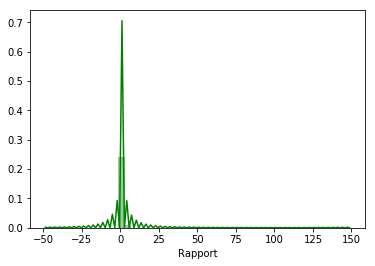

In [106]:
sns.distplot(DT2['Rapport'], color='g')

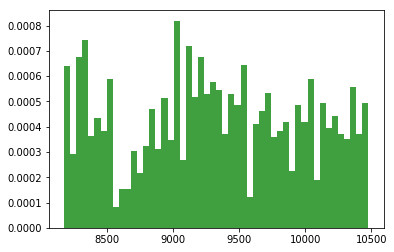

In [76]:
n, bins, patches = plt.hist(A['ST'], 50, density=1, facecolor='g', alpha=0.75)
plt.show()

In [81]:
col=np.ones(A.shape[0])
A['Sol']=col
B=A[['EntryID','SessionID','Sol']]
DT_bis=DT.merge(B,how='outer',on=['EntryID','SessionID'])
DT_bis['Sol']=DT_bis['Sol'].fillna(0)
DT_bis.loc[DT_bis['Sol']==1,:]
print(DT_bis)

,StartTime,SessionID,EntryID,UserID,Concurrency,EventID,Elapsed,Event Grade,User Grade,Grade,predict,Sol
5,2017-12-07 18:36:13.036,2933223,2,56574,2.0,BkTdY1qSc6,571,0.473133,0.382753,0.355652,181.718046,1.0
10,2018-03-09 13:38:09.830,3439653,8,56574,2.0,BkTdY1qSc6,543,0.473133,0.382753,0.355652,181.718046,1.0
23,2018-02-02 13:10:11.281,3230021,6,63523,2.0,BkTdY1qSc6,558,0.473133,0.461226,0.355652,250.417790,1.0
31,2017-12-11 17:35:16.151,2952535,9,22221581,2.0,BkTdY1qSc6,430,0.473133,0.345788,0.355652,149.356837,1.0
35,2017-12-21 14:15:17.708,2995964,7,63990,2.0,BkTdY1qSc6,1309,0.473133,0.793867,0.355652,541.629859,1.0
38,2018-01-18 14:22:51.451,3144898,15,63990,2.0,BkTdY1qSc6,1415,0.473133,0.793867,0.355652,541.629859,1.0
58,2017-12-21 17:03:17.488,2996609,10,1073692,2.0,BkTdY1qSc6,1079,0.473133,0.719527,0.355652,476.547945,1.0
73,2018-01-12 14:53:36.287,3110370,15,63345,2.0,BkTdY1qSc6,2138,0.473133,1.200139,0.355652,897.302052,1.0
168,2018-02-15 20:58:43.279,3309988,58,20915249,2.0,x84sljJzv,3512,0.909717,0.867749,0.355652,1254.347120,1.0
274,2018-01-12 18:30:37.390,3111749,97,61284,2.0,x84sljJzv,4643,0.909717,1.135097,0.355652,1488.397440,1.0


In [114]:
DT_bis.loc[DT_bis['Sol']==1,:].to_csv('Errors.csv')

In [ ]:
#Ajout d'une classification? Ajout d'une grade de jour (moyenne de temps, moyenne globale,..)

In [110]:
X = DT_bis.loc[:, ['Grade','User Grade','Event Grade']].values
y = DT_bis.loc[:, 'Sol'].values

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting classifier to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [111]:
print(cm)
    
#Appliquer le PCA dessus?

[[99001     0]
 [ 4522     0]]


## Linear regression with raw data (with Elapsed>5000)

In [123]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<10000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

ST=Dataset[['StartTime','SessionID','EntryID','UserID','Concurrency','EventID','Elapsed']]
ST=ST.merge(RS2,left_on='EventID',right_index=True)
ST=ST.merge(Res2,left_on='UserID',right_index=True)
ST=ST.merge(Conc,left_on='Concurrency',right_on='Concurrency')

In [124]:
X = ST.loc[:, ['Grade','User Grade','Event Grade']].values
y = ST.loc[:, 'Elapsed'].values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

import statsmodels.formula.api as sm
X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0, 1, 2, 3]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                 1.292e+05
Date:                Mon, 04 Jun 2018   Prob (F-statistic):               0.00
Time:                        11:34:17   Log-Likelihood:            -3.6247e+06
No. Observations:              432188   AIC:                         7.249e+06
Df Residuals:                  432184   BIC:                         7.249e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1679.3045      8.242   -203.743      0.000   -1695.459   -1663.150
x1          2092.5504     14.131    148.084      0.000    2064.854    2120.246
x2           953.6629      4.938    193.118      0.000     943.984     963.342
x3          1637.3668      2.982    549.075      0.000    1631.522    1643.212
==============================================================================
Omnibus:                   178011.061   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1451509.942
Skew:                           1.780   Prob(JB):                         0.00
Kurtosis:                      11.242   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
z=X*regressor_OLS.params
z=np.sum(z, axis=1)
print(z.shape)
ST['predict']=z

(432188,)


In [126]:
ST2=ST.loc[ST['Elapsed']>0,:]
col=ST2.apply(lambda row : row['predict']/row['Elapsed'],axis=1)
ST2['Rapport']=col
ST2['StartTime']=ST2['StartTime'].apply(transfo_date)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


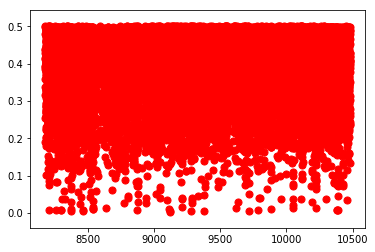

In [127]:
#print(DT2.loc[DT2['Rapport']>1,:].shape)
A=ST2.loc[ST2['Rapport']<0.5,:]
A=A.loc[A['Rapport']>0,:]
A['ST']=A['StartTime'].apply(perhour)
plt.scatter(A['ST'],A['Rapport'],s=50,c='red',label ='1')
plt.show()
#print(DT2.shape)

In [131]:
col=np.ones(A.shape[0])
A['Sol']=col
B=A[['EntryID','SessionID','Sol']]
ST_bis=ST.merge(B,how='outer',on=['EntryID','SessionID'])
ST_bis['Sol']=ST_bis['Sol'].fillna(0)
ST_bis.loc[ST_bis['Sol']==1,:]
print(ST_bis)

                      StartTime  SessionID  EntryID     UserID  Concurrency  \
0       2017-12-07 18:21:24.543    2933180        6    8941569          2.0   
1       2017-12-15 18:08:15.864    2972404       17    8941569          2.0   
2       2017-12-22 11:18:05.539    3001198       27    8941569          2.0   
3       2018-01-05 13:29:08.364    3065250       38    8941569          2.0   
4       2018-01-19 16:39:20.587    3153797       53    8941569          2.0   
5       2017-12-07 18:36:13.036    2933223        2      56574          2.0   
6       2017-12-15 13:13:49.112    2970561        4      56574          2.0   
7       2017-12-15 13:18:20.478    2970561        8      56574          2.0   
8       2018-01-19 12:45:40.013    3151977       14      56574          2.0   
9       2018-03-02 12:19:19.863    3400428        6      56574          2.0   
10      2018-03-09 13:38:09.830    3439653        8      56574          2.0   
11      2017-12-07 18:41:58.707    2933238        3 

[432188 rows x 12 columns]


In [1]:
print(ST_bis.loc[ST_bis['Sol']==1,:].shape[0])
print(ST_bis.loc[ST_bis['Elapsed']>5000,:])
Q=ST_bis.loc[ST_bis['Elapsed']>5000,:]
print(Q.loc[Q['Sol']==1,:].shape[0])

NameError: name 'ST_bis' is not defined

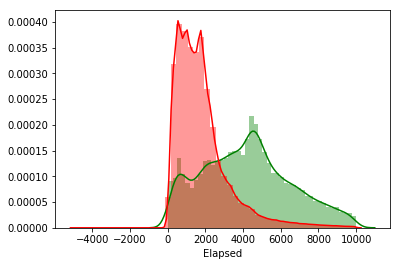

In [147]:
Q=ST_bis.loc[ST_bis['Sol']==1,:]
sns.distplot(Q['Elapsed'], color='g')
sns.distplot(ST_bis['Elapsed'], color='r')

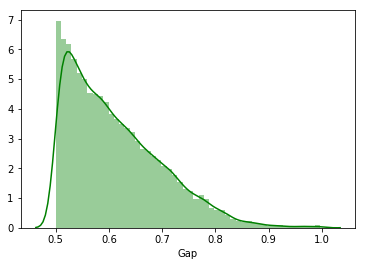

In [156]:
# Relative gap for long requests
Q=ST_bis.loc[ST_bis['Sol']==1,:]
Q=Q.loc[Q['Elapsed']>0,:]
col=Q.apply( lambda row : ( row['Elapsed'] - row['predict'] ) / row['Elapsed'], axis = 1 )
Q['Gap']=col
sns.distplot(Q['Gap'], color='g')

In [ ]:
# Try to cluster according to the gap between pred and actual and the relative gap

## PCA attempt

In [ ]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<10000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

QT=Dataset[['StartTime','SessionID','EntryID','UserID','Concurrency','EventID','Elapsed']]
QT=QT.merge(RS2,left_on='EventID',right_index=True)
QT=QT.merge(Res2,left_on='UserID',right_index=True)
QT=QT.merge(Conc,left_on='Concurrency',right_on='Concurrency')

In [137]:
X = QT.loc[:, ['Grade','User Grade','Event Grade']].values
y = QT.loc[:, 'Elapsed'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [138]:
print(explained_variance)
#The explained variance shows that it would be useless to try to reduce dimensions

[0.37195756 0.33056992 0.29747251]


## SVR Attempt

In [5]:
Dataset=pandas.read_csv('Concrrencies_allservers.csv')
Dataset=Dataset[['SessionID','EntryID','UserID','EventID','Type','WorkspaceID','StartTime','EndTime','Elapsed','ServerIP','Concurrency']]
Dataset=Dataset.loc[Dataset['Elapsed']<10000,:]
####### Enlever les Elapsed>5000
User_requests=Dataset[['EventID','UserID','Elapsed']]
User_requests=User_requests.groupby(by=['UserID','EventID']).mean()
User_requests.to_csv('Usrreq.csv')
User_requests=pandas.read_csv('Usrreq.csv')
User_requests.columns=['UserID','EventID','Mean User requests']
Req=Dataset[['EventID','Elapsed']]
Req=Req.groupby(by='EventID').mean()
Req.columns=['Mean req time']
Res=User_requests.merge(Req,left_on='EventID',right_index=True)
col=Res.apply( lambda row : row['Mean User requests']/row['Mean req time'], axis=1)
Res['User Grade']=col
Res2=Res[['UserID','User Grade']]
Res2=Res2.groupby(by='UserID').mean()
#Res2.to_csv('Mean_time user.csv[]'')

USR=pandas.read_csv('Usrreq.csv')
USR.columns=['UserID','EventID','Mean User requests']
RQ=Dataset[['UserID','Elapsed']]
RQ=RQ.groupby(by='UserID').mean()
RQ.columns=['Mean user time']
RS=USR.merge(RQ,left_on='UserID',right_index=True)
col=RS.apply( lambda row : row['Mean User requests']/row['Mean user time'], axis=1)
RS['Event Grade']=col
RS2=RS[['EventID','Event Grade']]
RS2=RS2.groupby(by='EventID').mean()

QT=Dataset[['StartTime','SessionID','EntryID','UserID','Concurrency','EventID','Elapsed']]
QT=QT.merge(RS2,left_on='EventID',right_index=True)
QT=QT.merge(Res2,left_on='UserID',right_index=True)
QT=QT.merge(Conc,left_on='Concurrency',right_on='Concurrency')

In [ ]:
X = QT.loc[:, ['Grade','User Grade','Event Grade']].values
y = QT.loc[:, 'Elapsed'].values

# Splitting the dataset into the Training set and Test set
"""from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)"""

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y= y.reshape(-1, 1)
y = sc_y.fit_transform(y)

# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## SGD Regressor

In [11]:
X = QT.loc[:, ['Grade','User Grade','Event Grade']].values
y = QT.loc[:, 'Elapsed'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.linear_model import SGDRegressor
regressor = SGDRegressor()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

print(regressor.score(X_test, y_test))





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.4689104617416162


AttributeError: 'SGDRegressor' object has no attribute 'params'

In [ ]:
## Add a linear regression to calculate the conc grade